# Tarea 4 Alonso Espinoza Correa

## Algoritmo SIMPLE

El algoritmo SIMPLE es un algoritmo que permite obtener la ecuación de conservación de momentum y la de conservación de masa en un flujo simultáneamente. Para eso, se realiza en una *staggred grid* como la que se muestra en la siguiente imagen, donde cada malla se utiliza para resolver una sola variable.

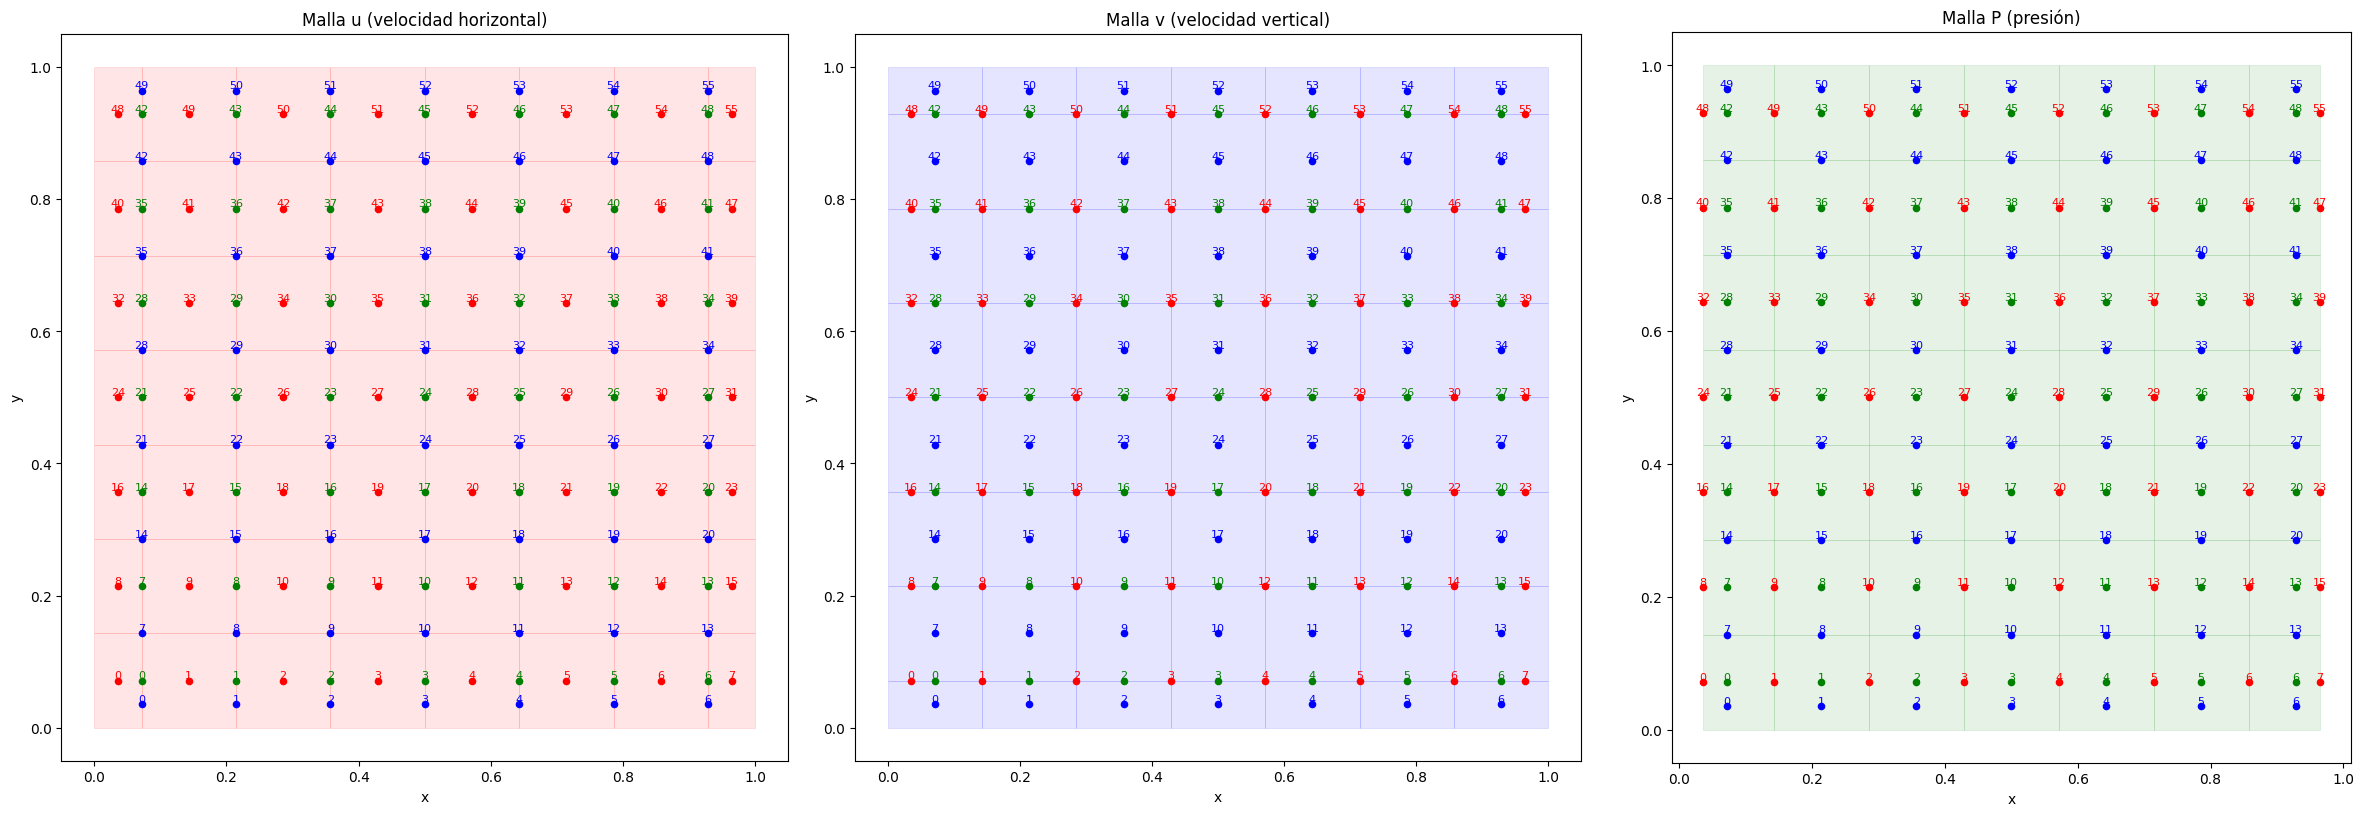

En principio del algoritmo es explicado a continuación:

1) Inicialmente le entregamos al algoritmo valores iniciales de $u$, $v$ y $P$ (velocidades y presión)
2) Utilizando el método de volúmenes finitos en la malla de $u$, se resuelve la conservación de momentum en $x$. La ecuación debiese quedar de la forma $a_{p}u^*_p = \sum_{vecinos} a_{i}u^*_i + \Delta x (P_w - P_e) + b$, donde $b$ es un término de fuente que aparece en las condiciones de frontera.
3) De manera análoga, se resuelve la ecuación de conservación de momentum en $y$ para obtener $a_{P}v^*_p = \sum_{vecinos} a_{i}v^*_i + \Delta y (P_s - P_n) + b$
4) Se definen las correcciones $u = u^* + u'$, $v = v^* + v'$, $P = P^* + P'$
5) Se plantea la ecuación de conservación de momentum para las correcciones despreciando los términos de los nodos vecinos y los nodos de fuente, de forma que se obtiene $a_p u_p' = \Delta x (P_w' - P_e')$ y $a_p v_p' = \Delta y (P_s' - P_n')$
6) Se plantea la ecuación de continuidad vista desde la malla de presión, con las velocidades expresadas en función de $u^*$, $v^*$ (conocidos) y $P'$ (desconocido). Usando volúmenes finitos, se obtiene algo de la forma $\beta_p P'_p = \sum_{vecinos} \beta_{i}P^*_i + b$, donde $b$ dependerá de las velocidades calculadas en 2 y 3.
7) Si es que no se asegura convergencia, se vuelve a iniciar el algoritmo, pero ahora con las velocidades actualizadas y la presión actualizadas con un factor de relajación $u_{new} = \alpha_u (u^* + u') + (1 - \alpha_u) u_{old}$, $v_{new} = \alpha_v (v^* + v') + (1 - \alpha_v) v_{old}$, $P_{new} = \alpha_P (P^* + P')$

## Desarrollo de las ecuaciones

En las siguientes fotos se muestra el desarrollo de las ecuaciones de continuidad y conservación de momentum para implementarla con el algoritmo SIMPLE

![Tarea 4 CFD-01.jpg](<attachment:Tarea 4 CFD-01.jpg>) ![Tarea 4 CFD-02.jpg](<attachment:Tarea 4 CFD-02.jpg>) ![Tarea 4 CFD-03.jpg](<attachment:Tarea 4 CFD-03.jpg>) ![Tarea 4 CFD-04.jpg](<attachment:Tarea 4 CFD-04.jpg>) ![Tarea 4 CFD-05.jpg](<attachment:Tarea 4 CFD-05.jpg>) ![Tarea 4 CFD-06.jpg](<attachment:Tarea 4 CFD-06.jpg>) ![Tarea 4 CFD-07.jpg](<attachment:Tarea 4 CFD-07.jpg>) ![Tarea 4 CFD-08.jpg](<attachment:Tarea 4 CFD-08.jpg>) ![Tarea 4 CFD-09.jpg](<attachment:Tarea 4 CFD-09.jpg>) ![Tarea 4 CFD-10.jpg](<attachment:Tarea 4 CFD-10.jpg>) ![Tarea 4 CFD-11.jpg](<attachment:Tarea 4 CFD-11.jpg>) ![Tarea 4 CFD-12.jpg](<attachment:Tarea 4 CFD-12.jpg>) ![Tarea 4 CFD-13.jpg](<attachment:Tarea 4 CFD-13.jpg>)
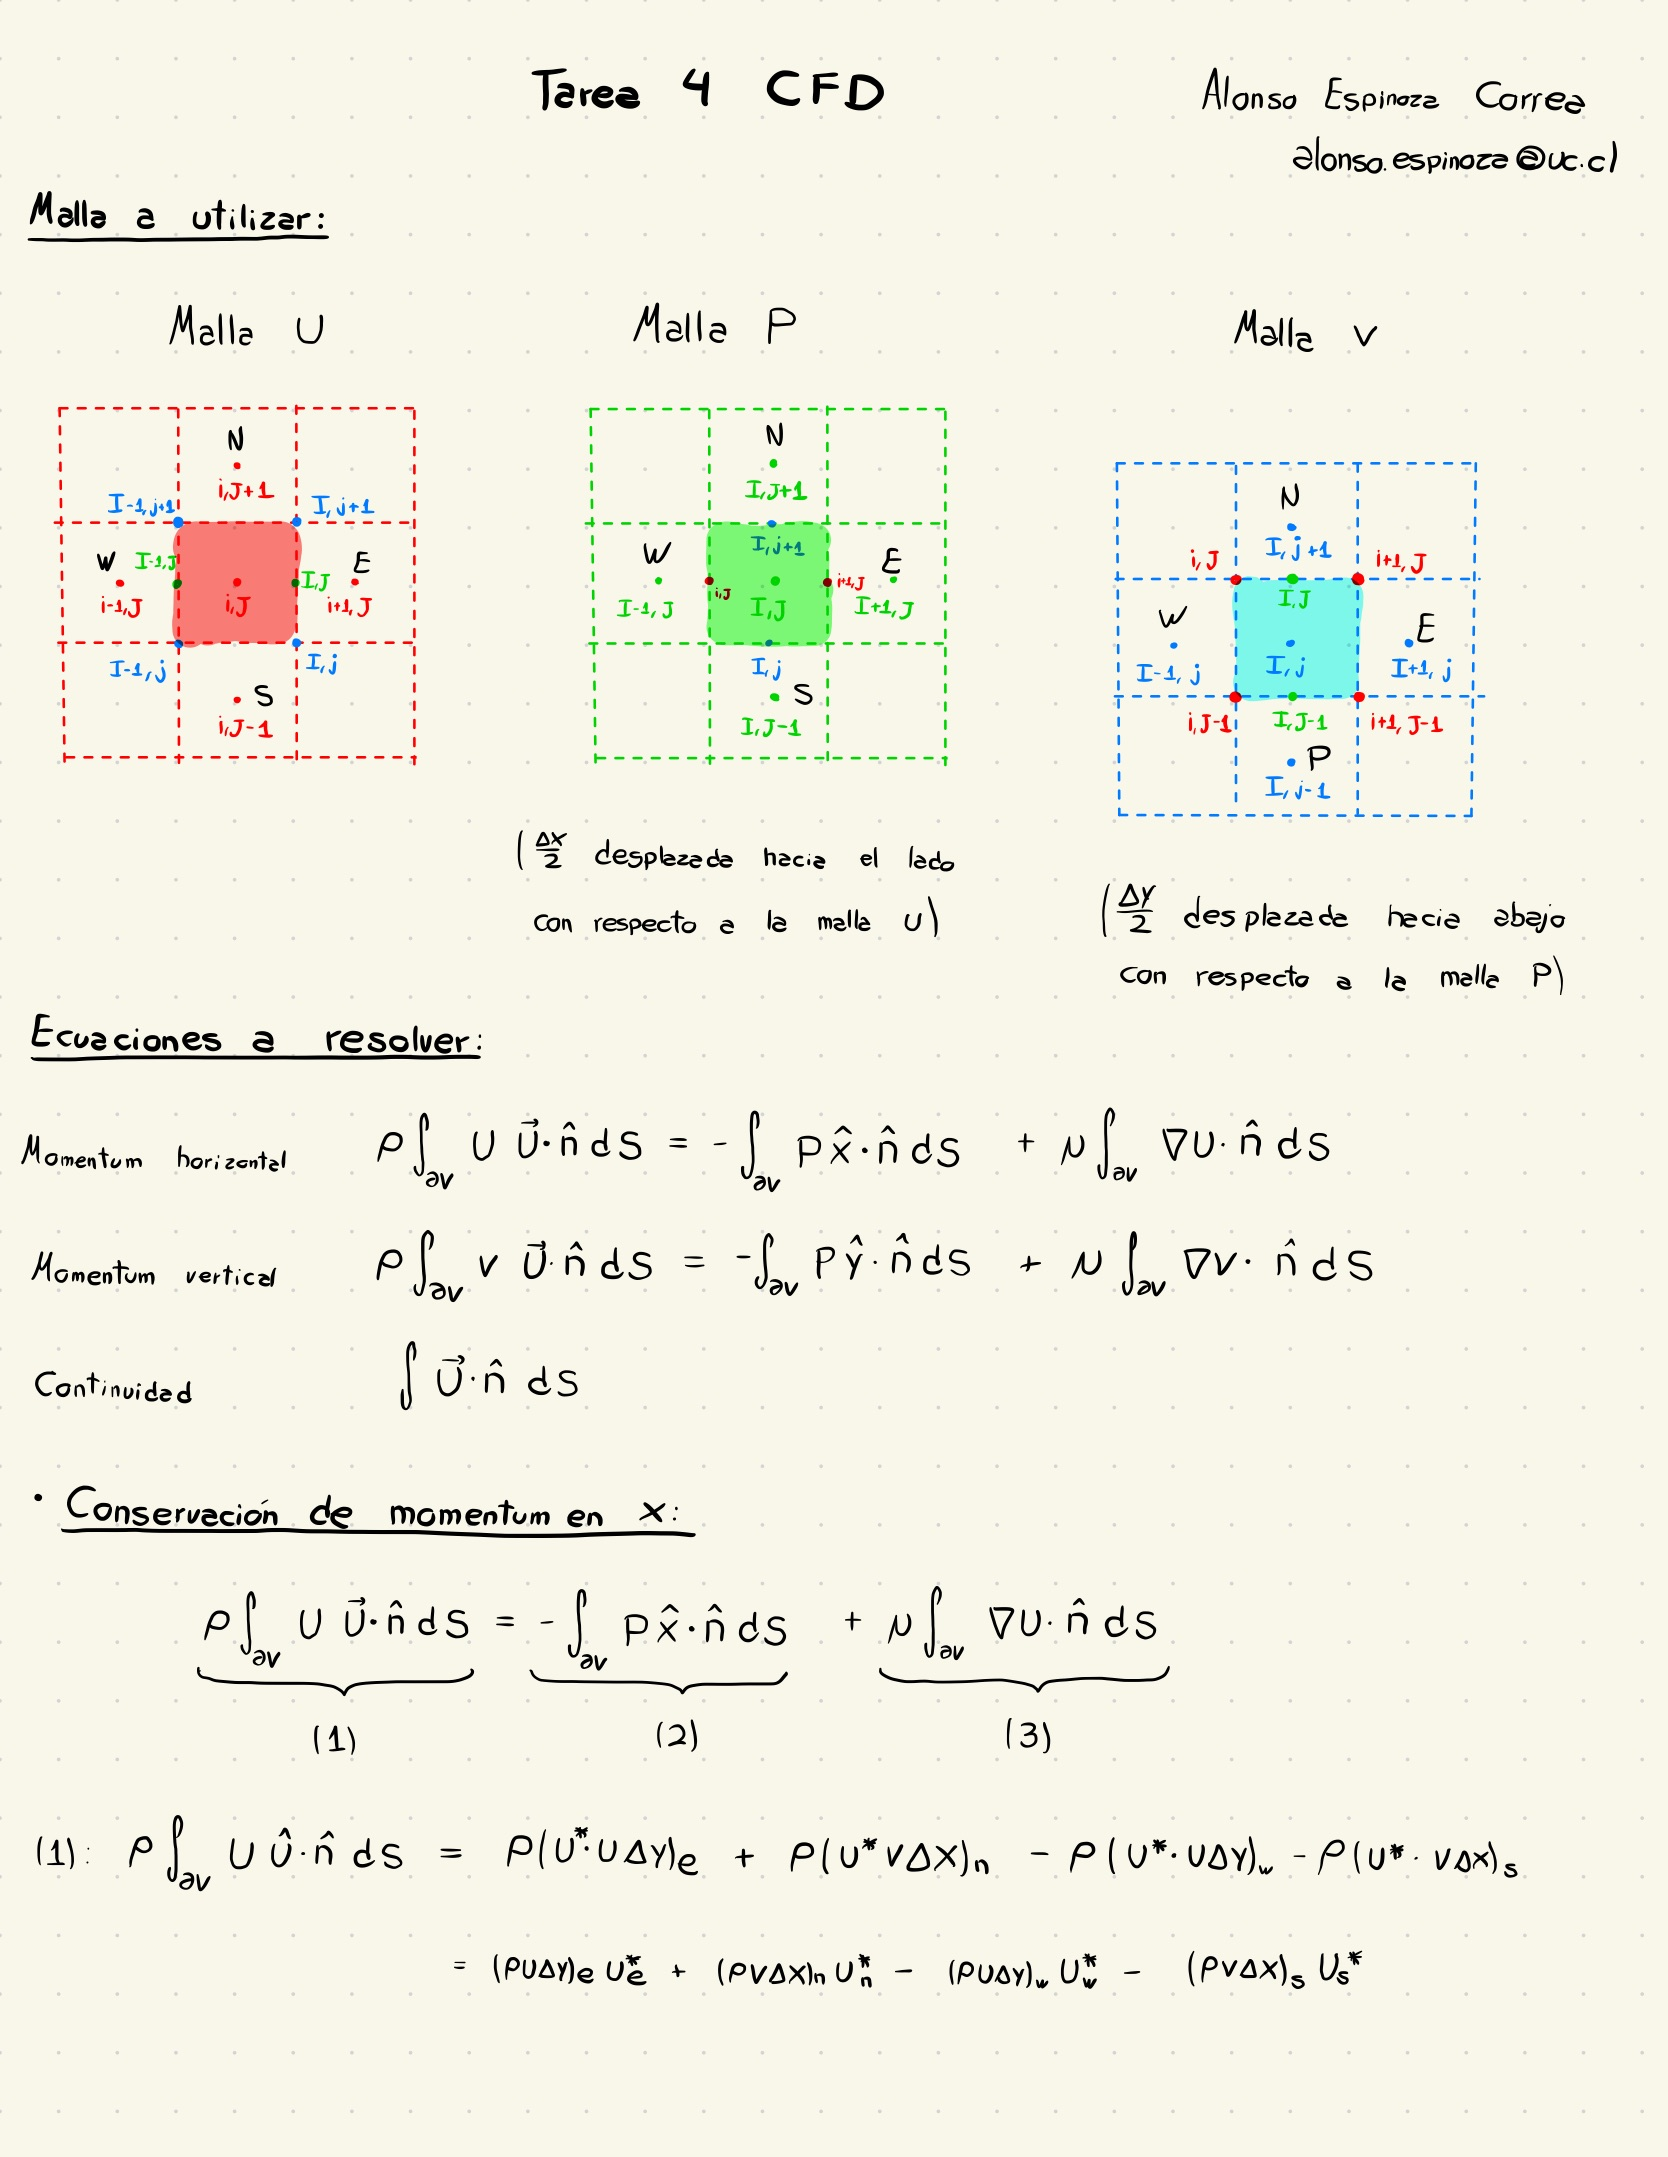
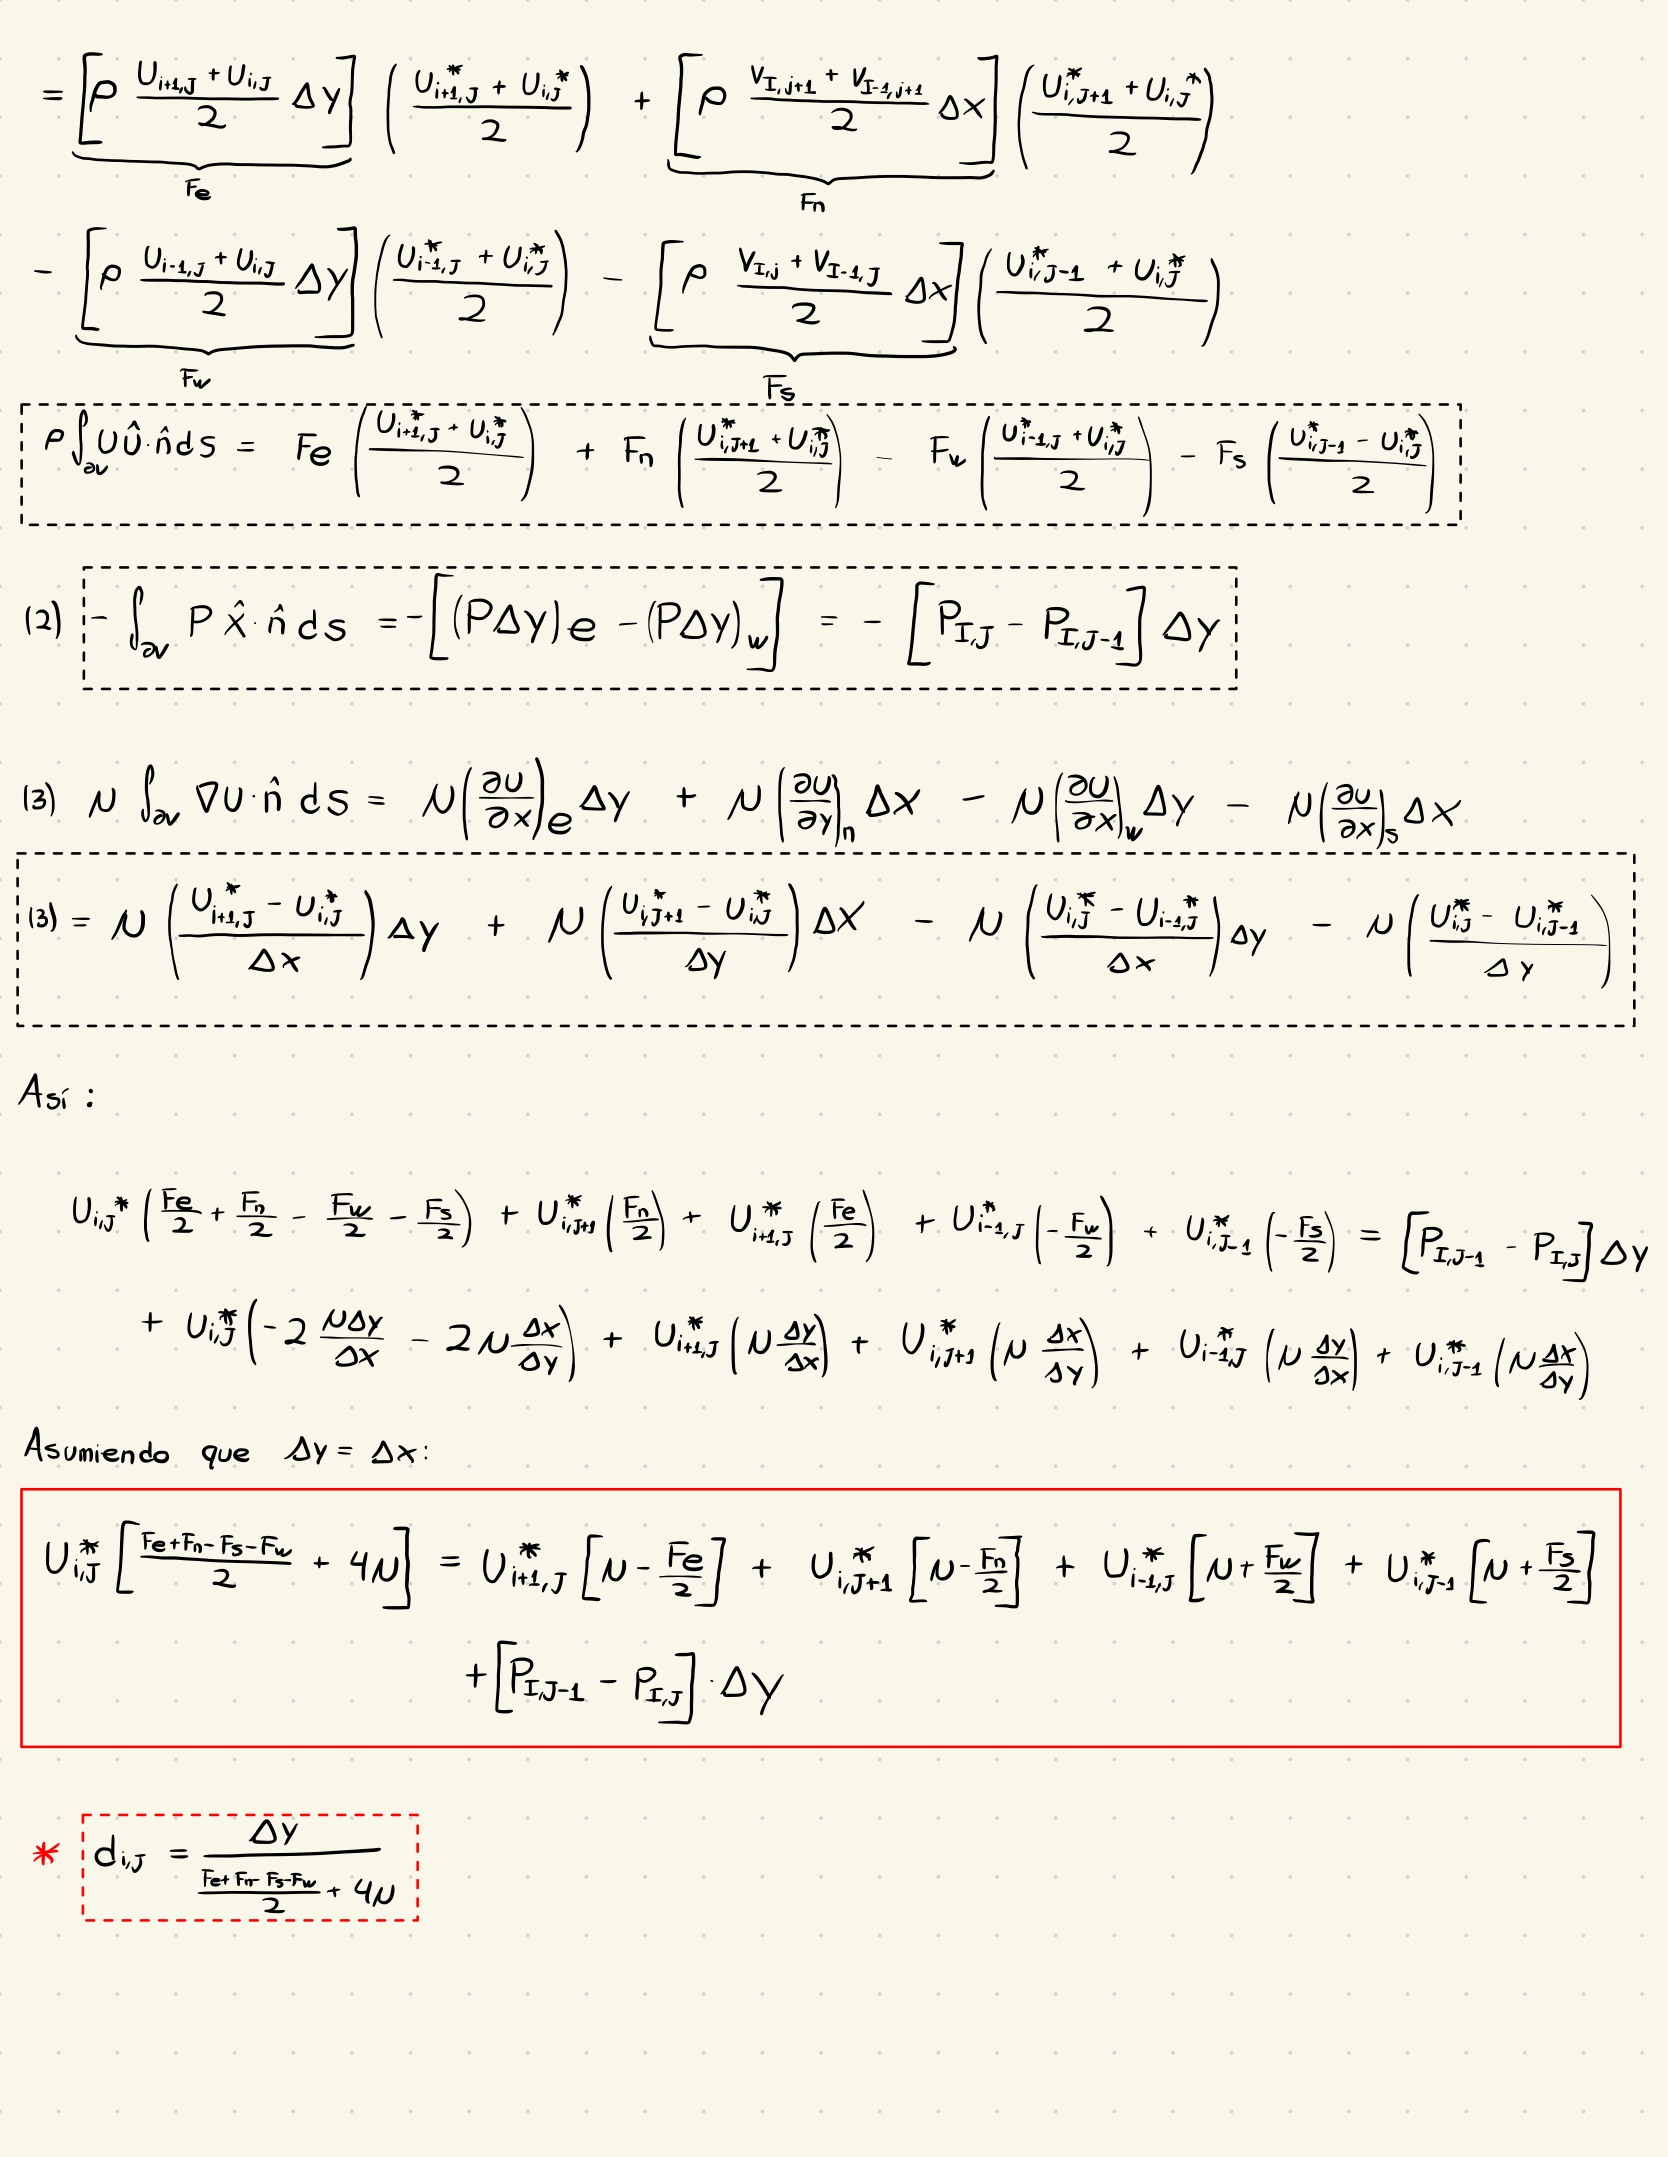
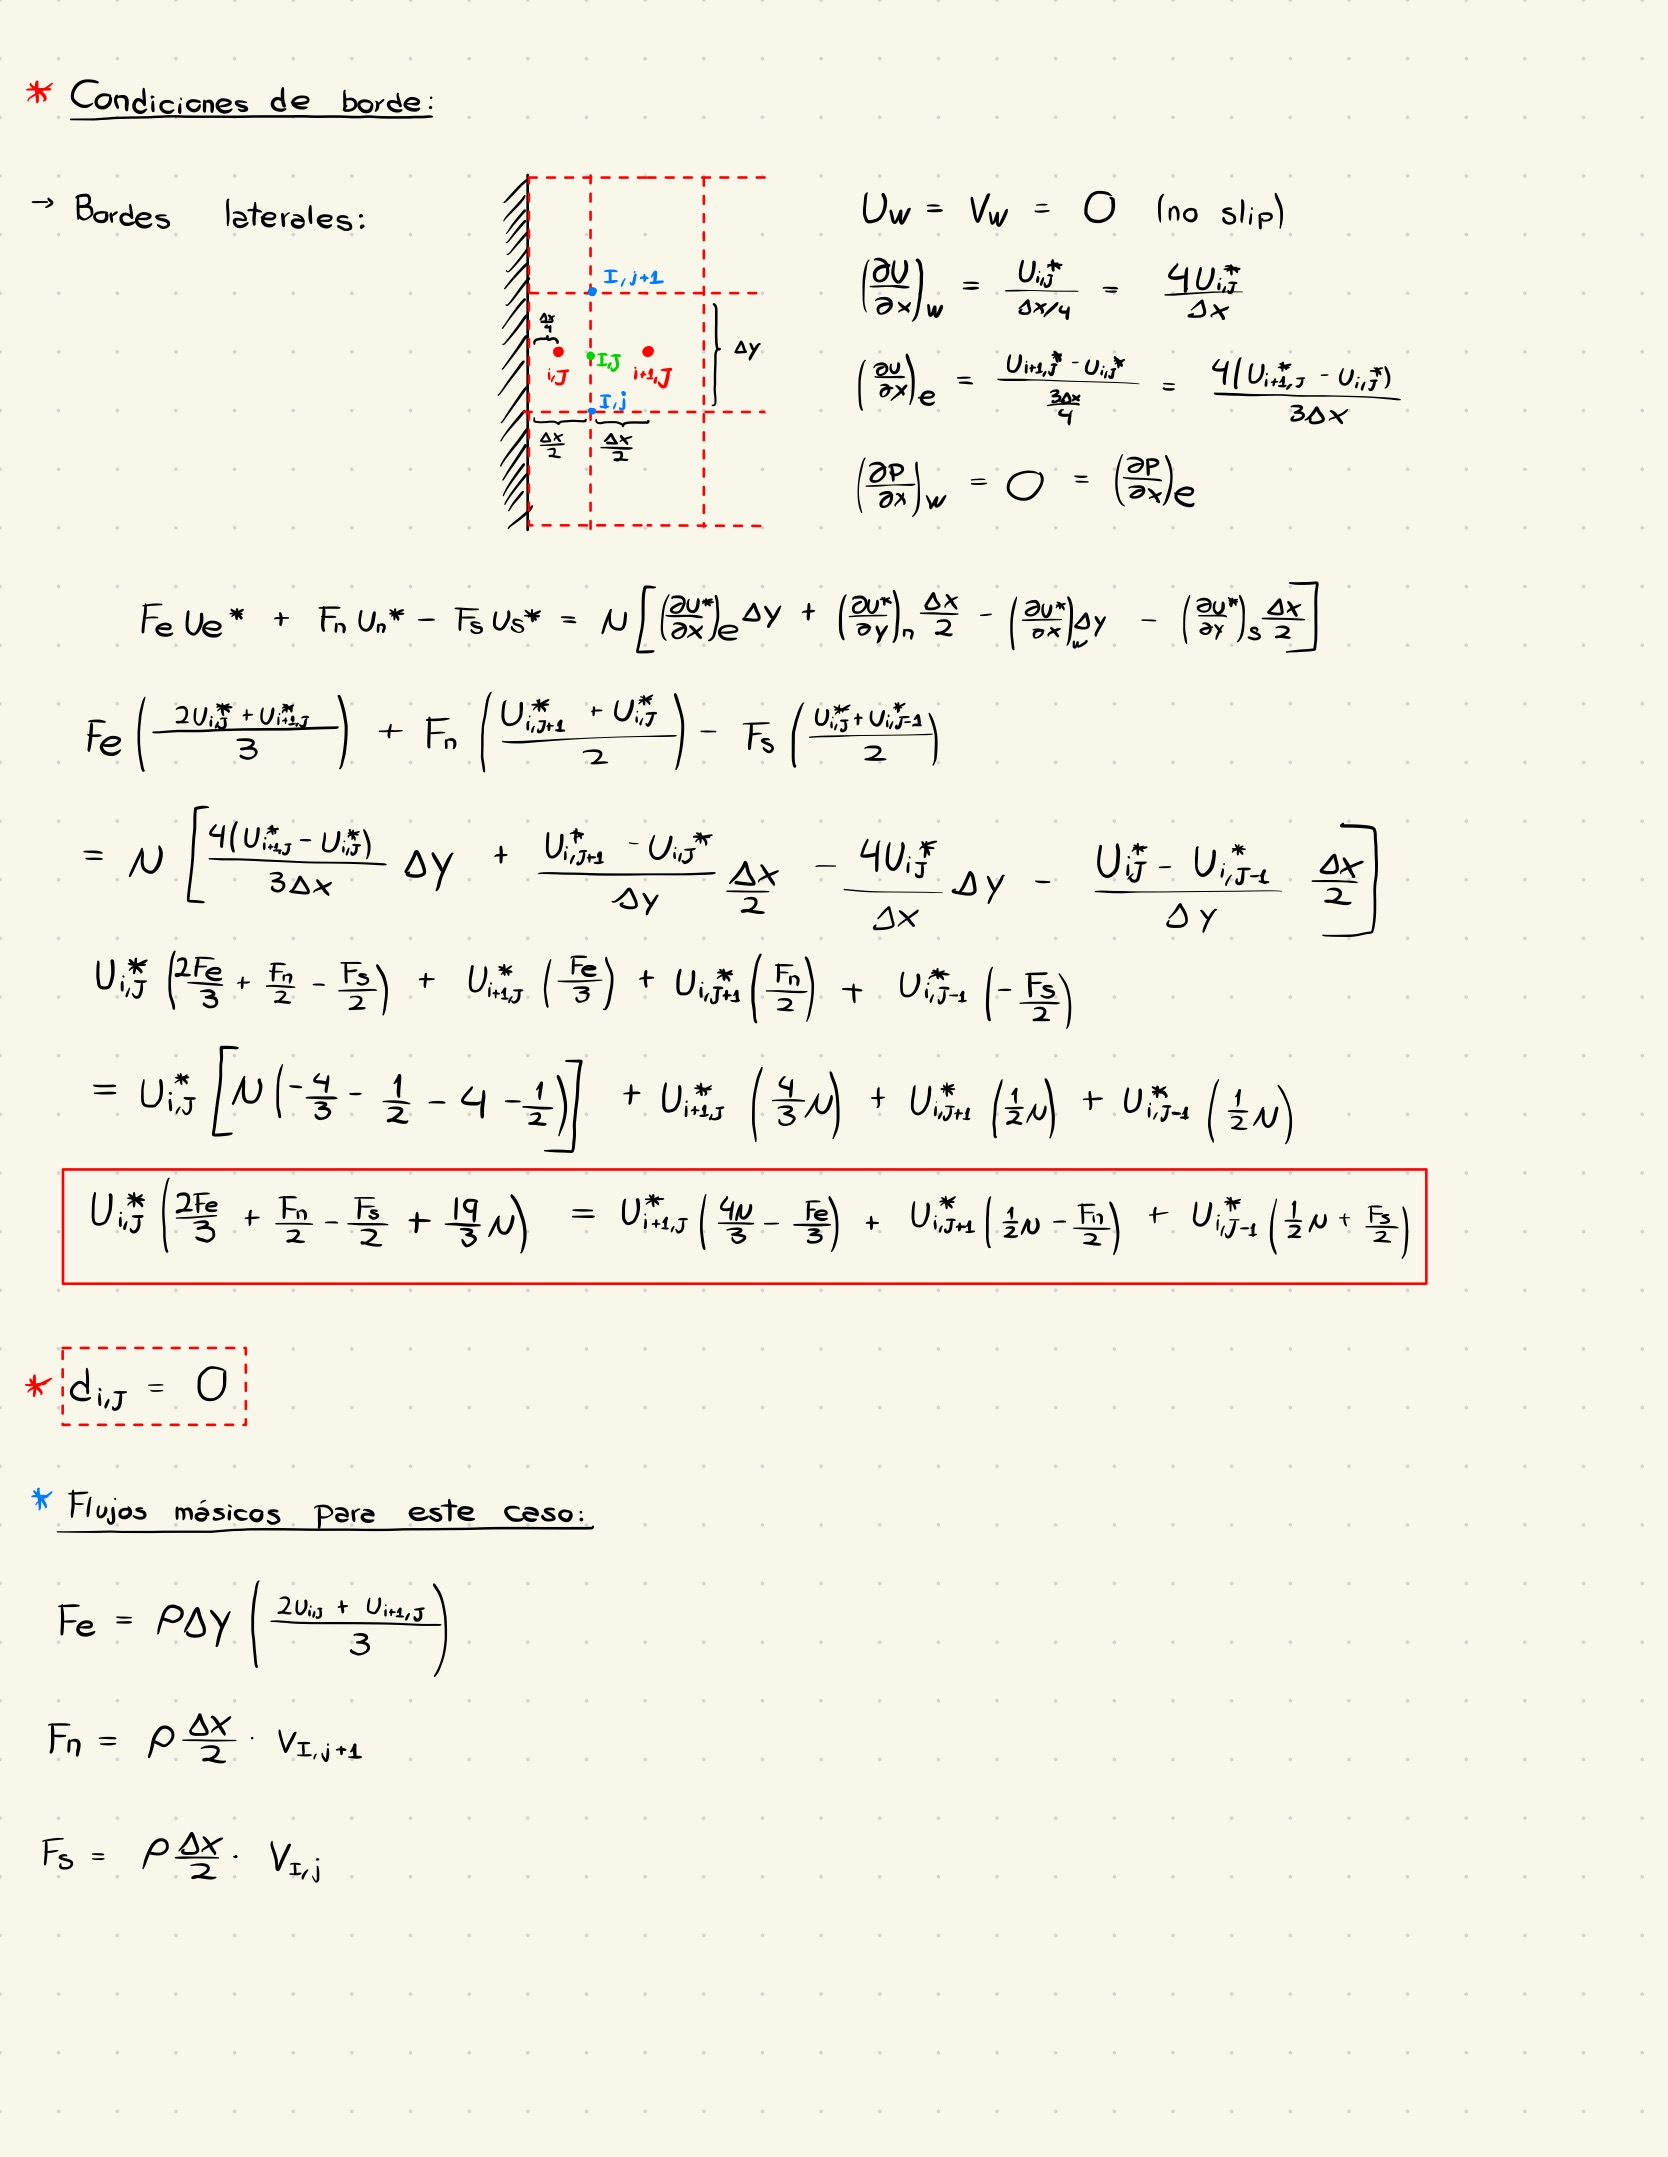
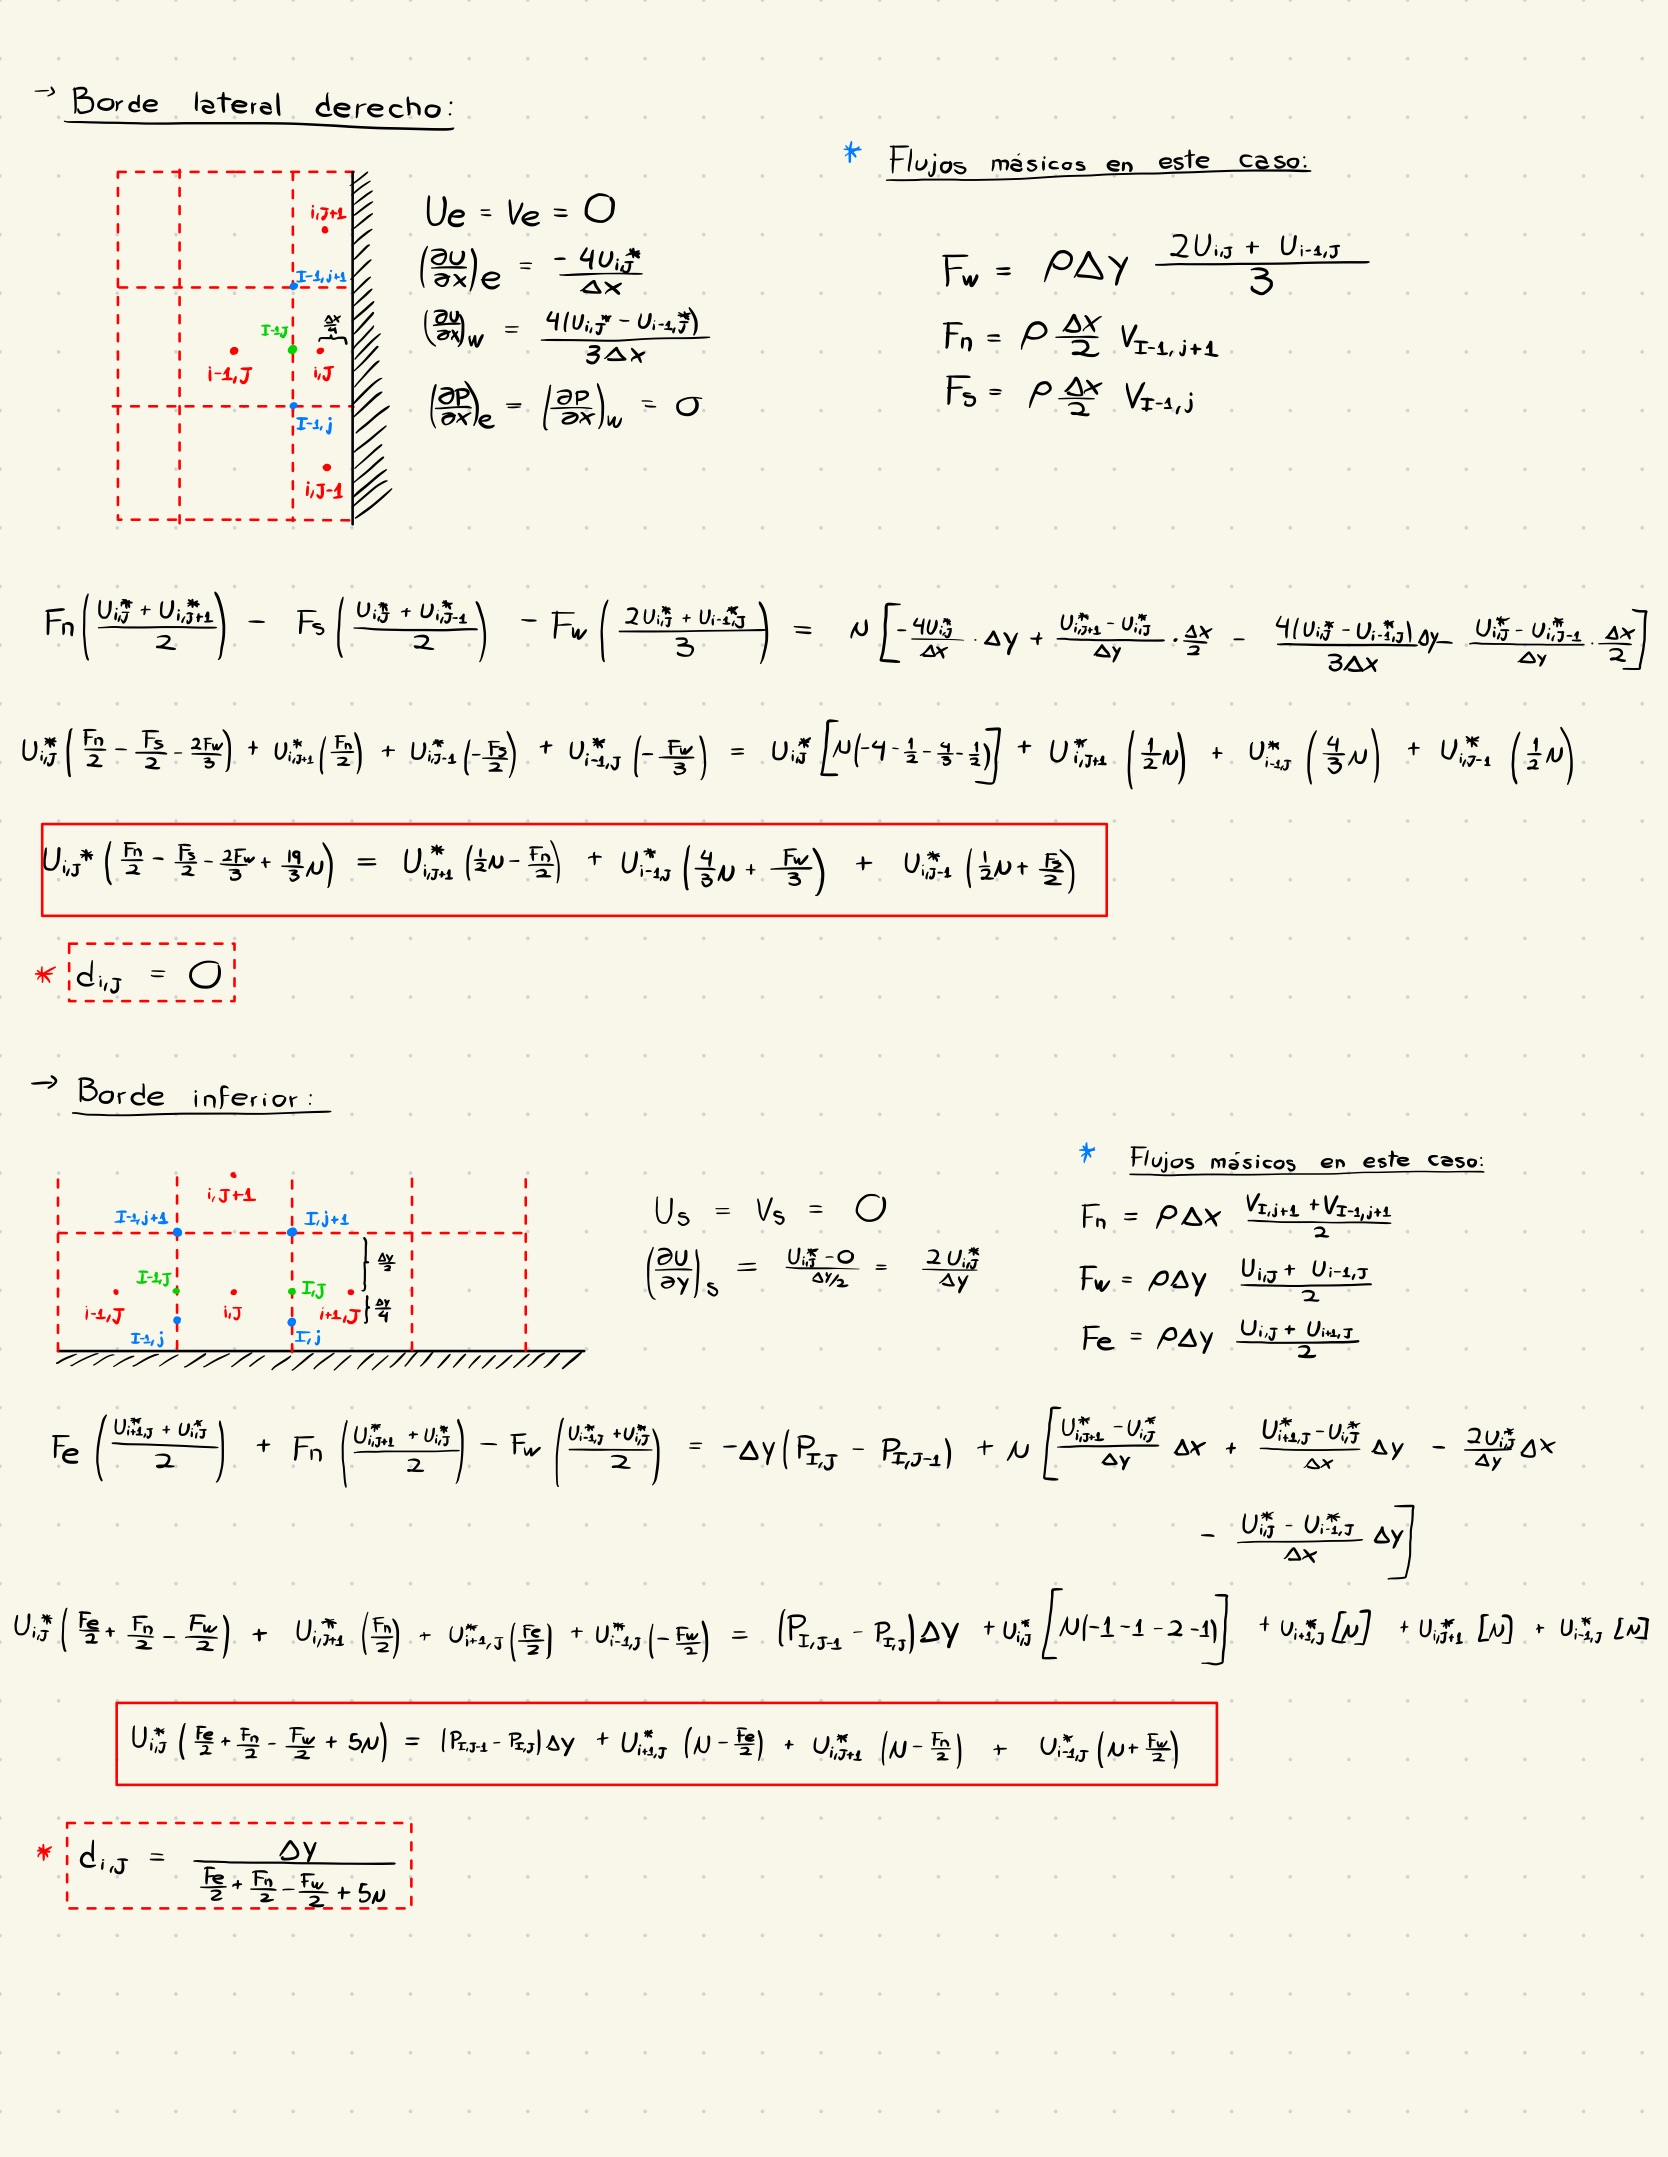
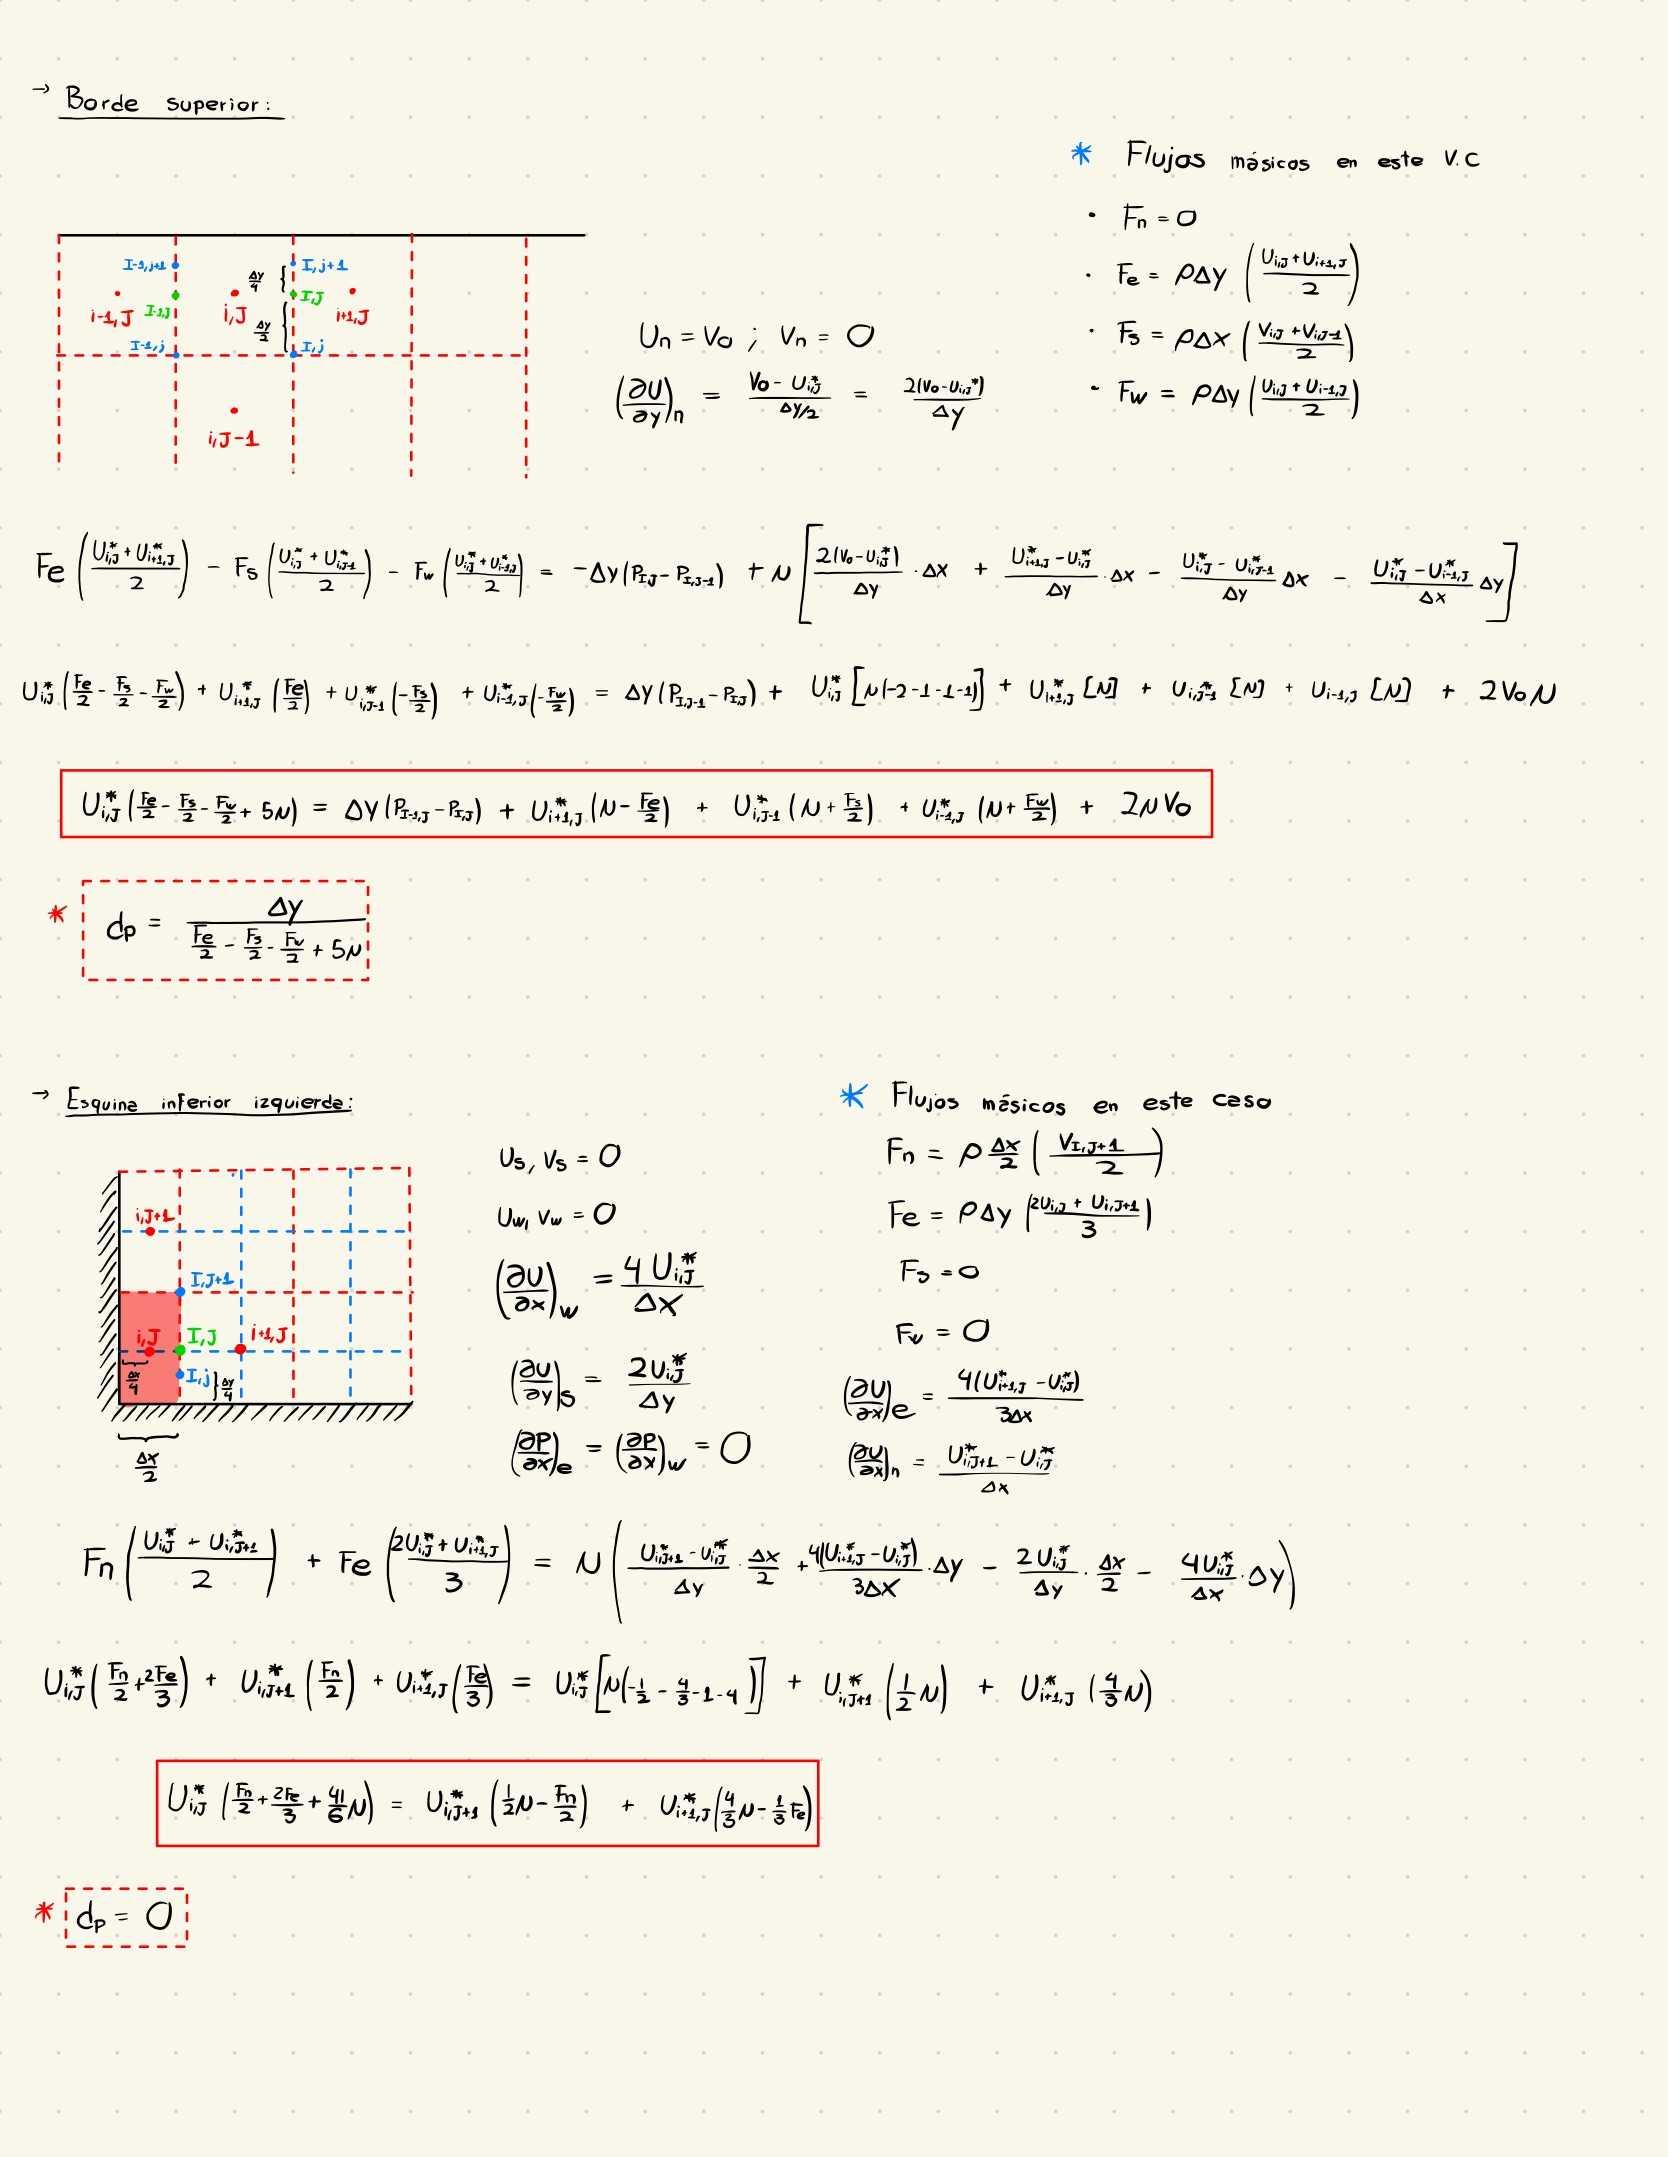
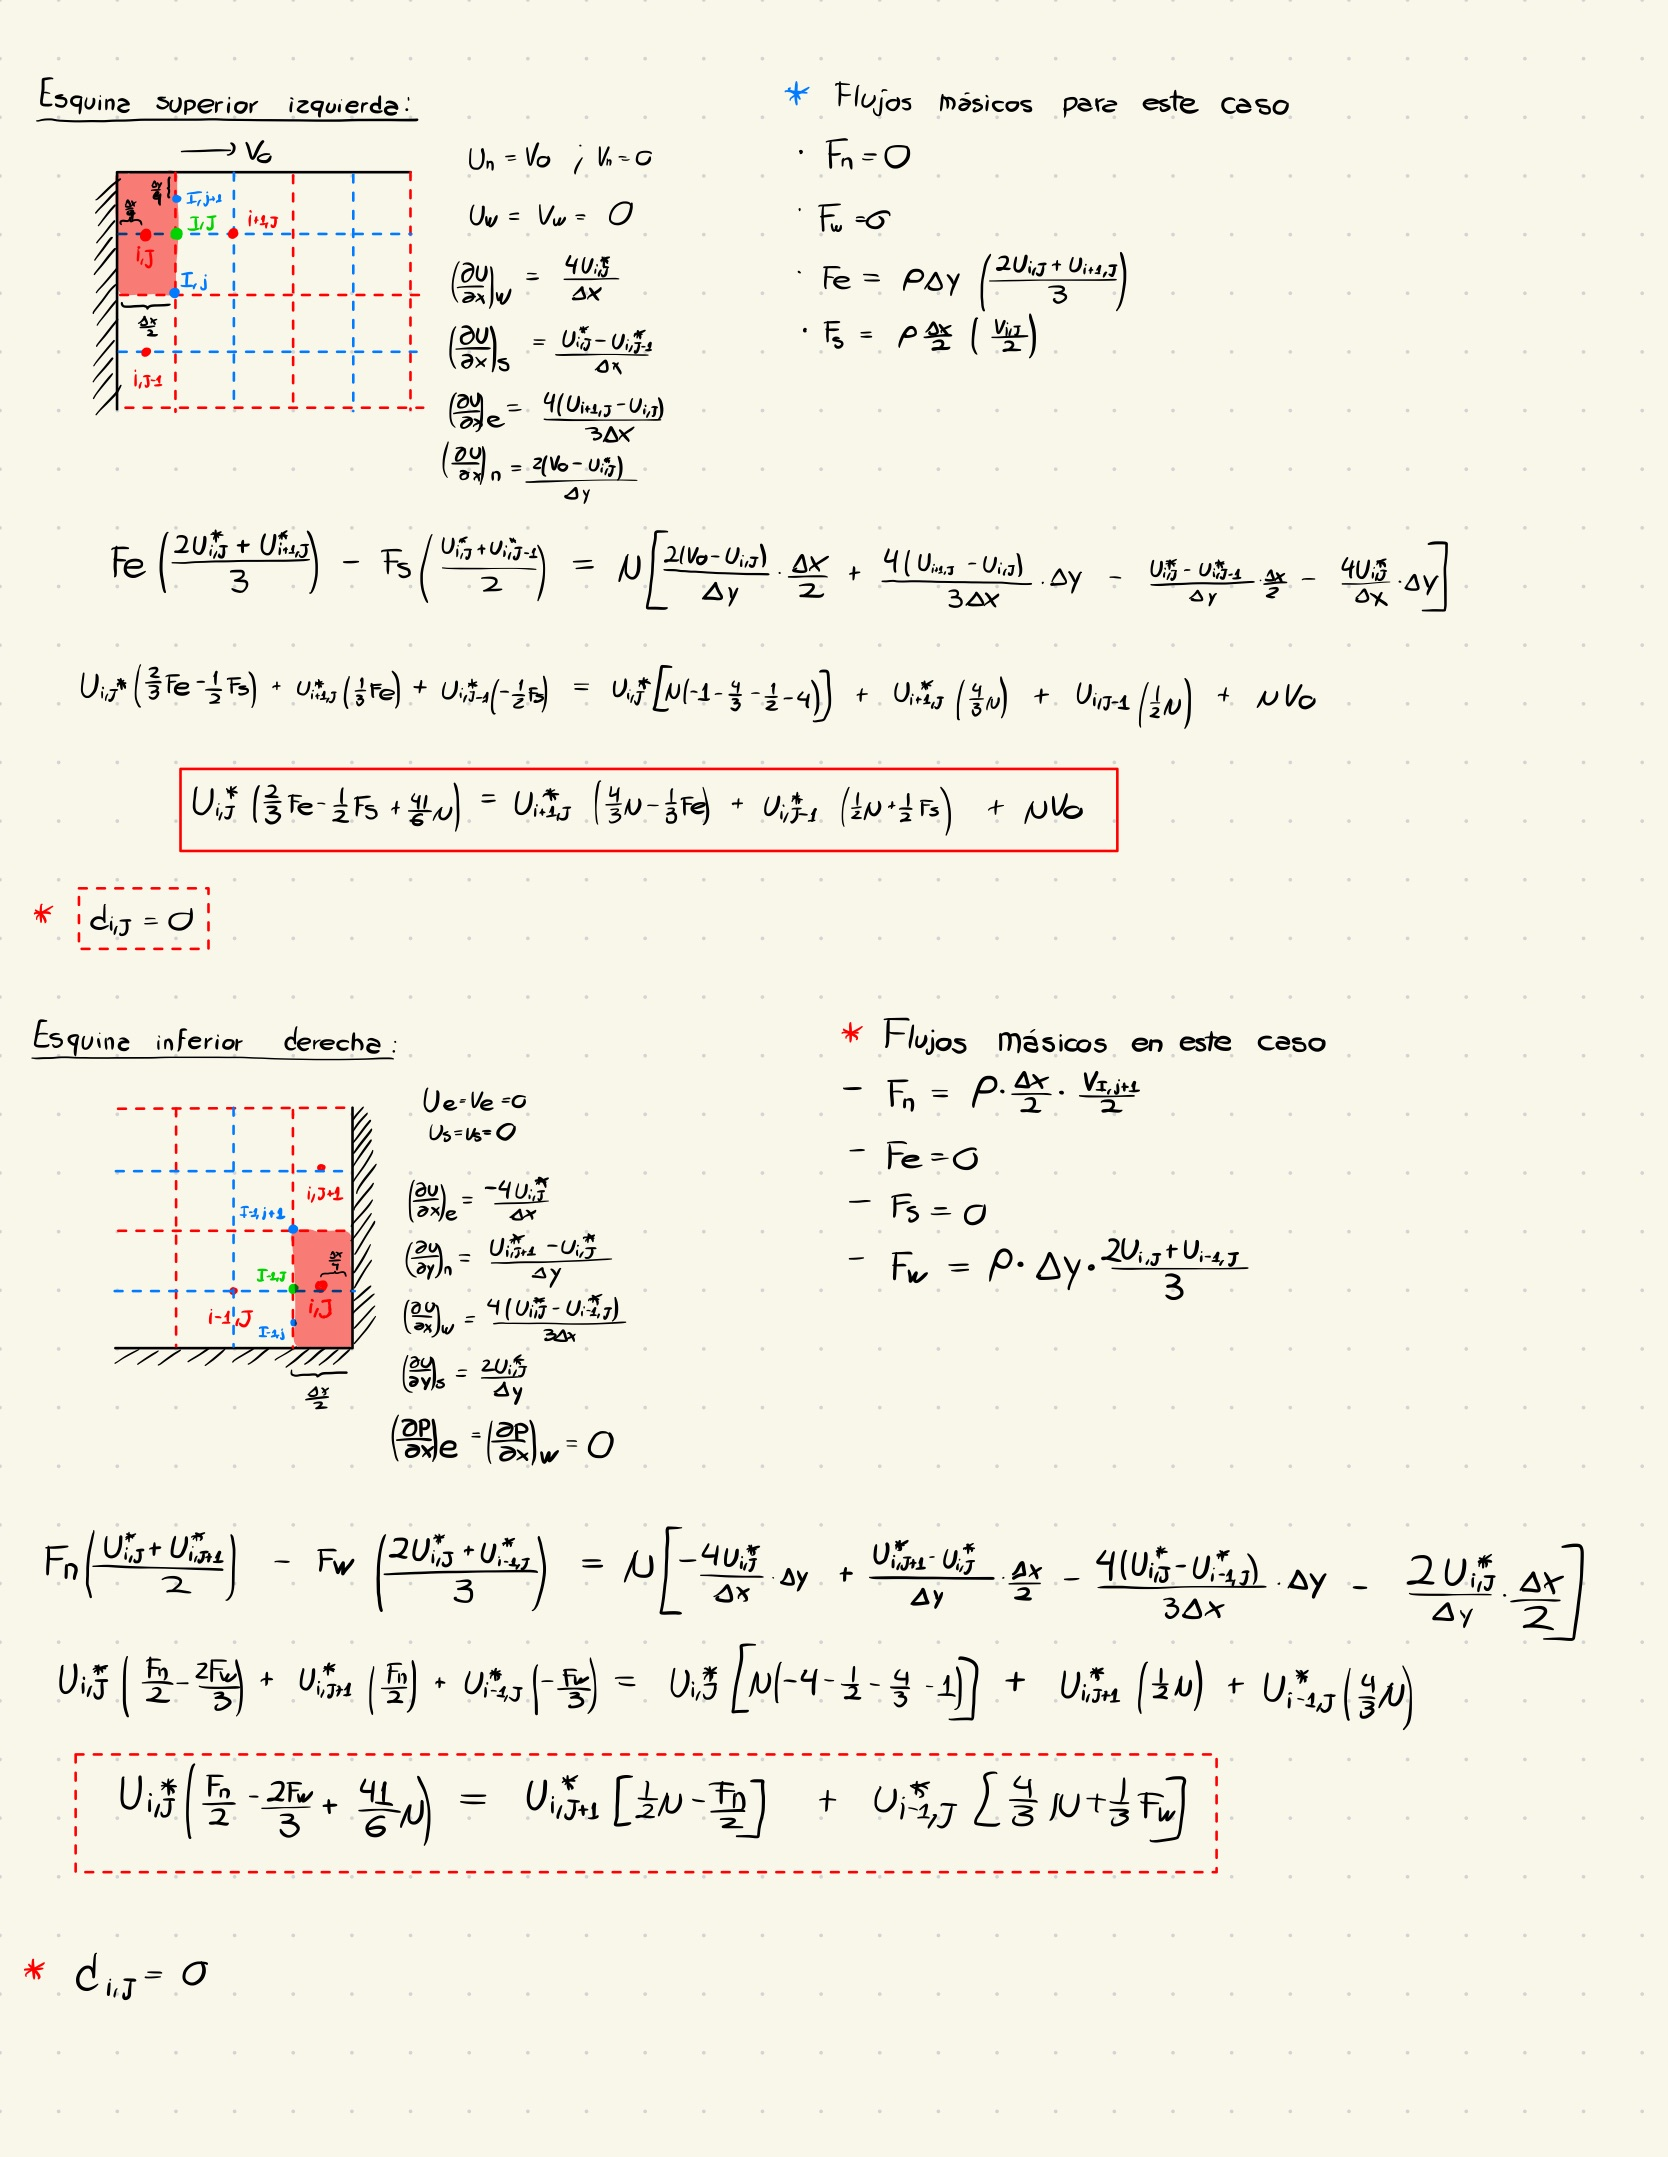
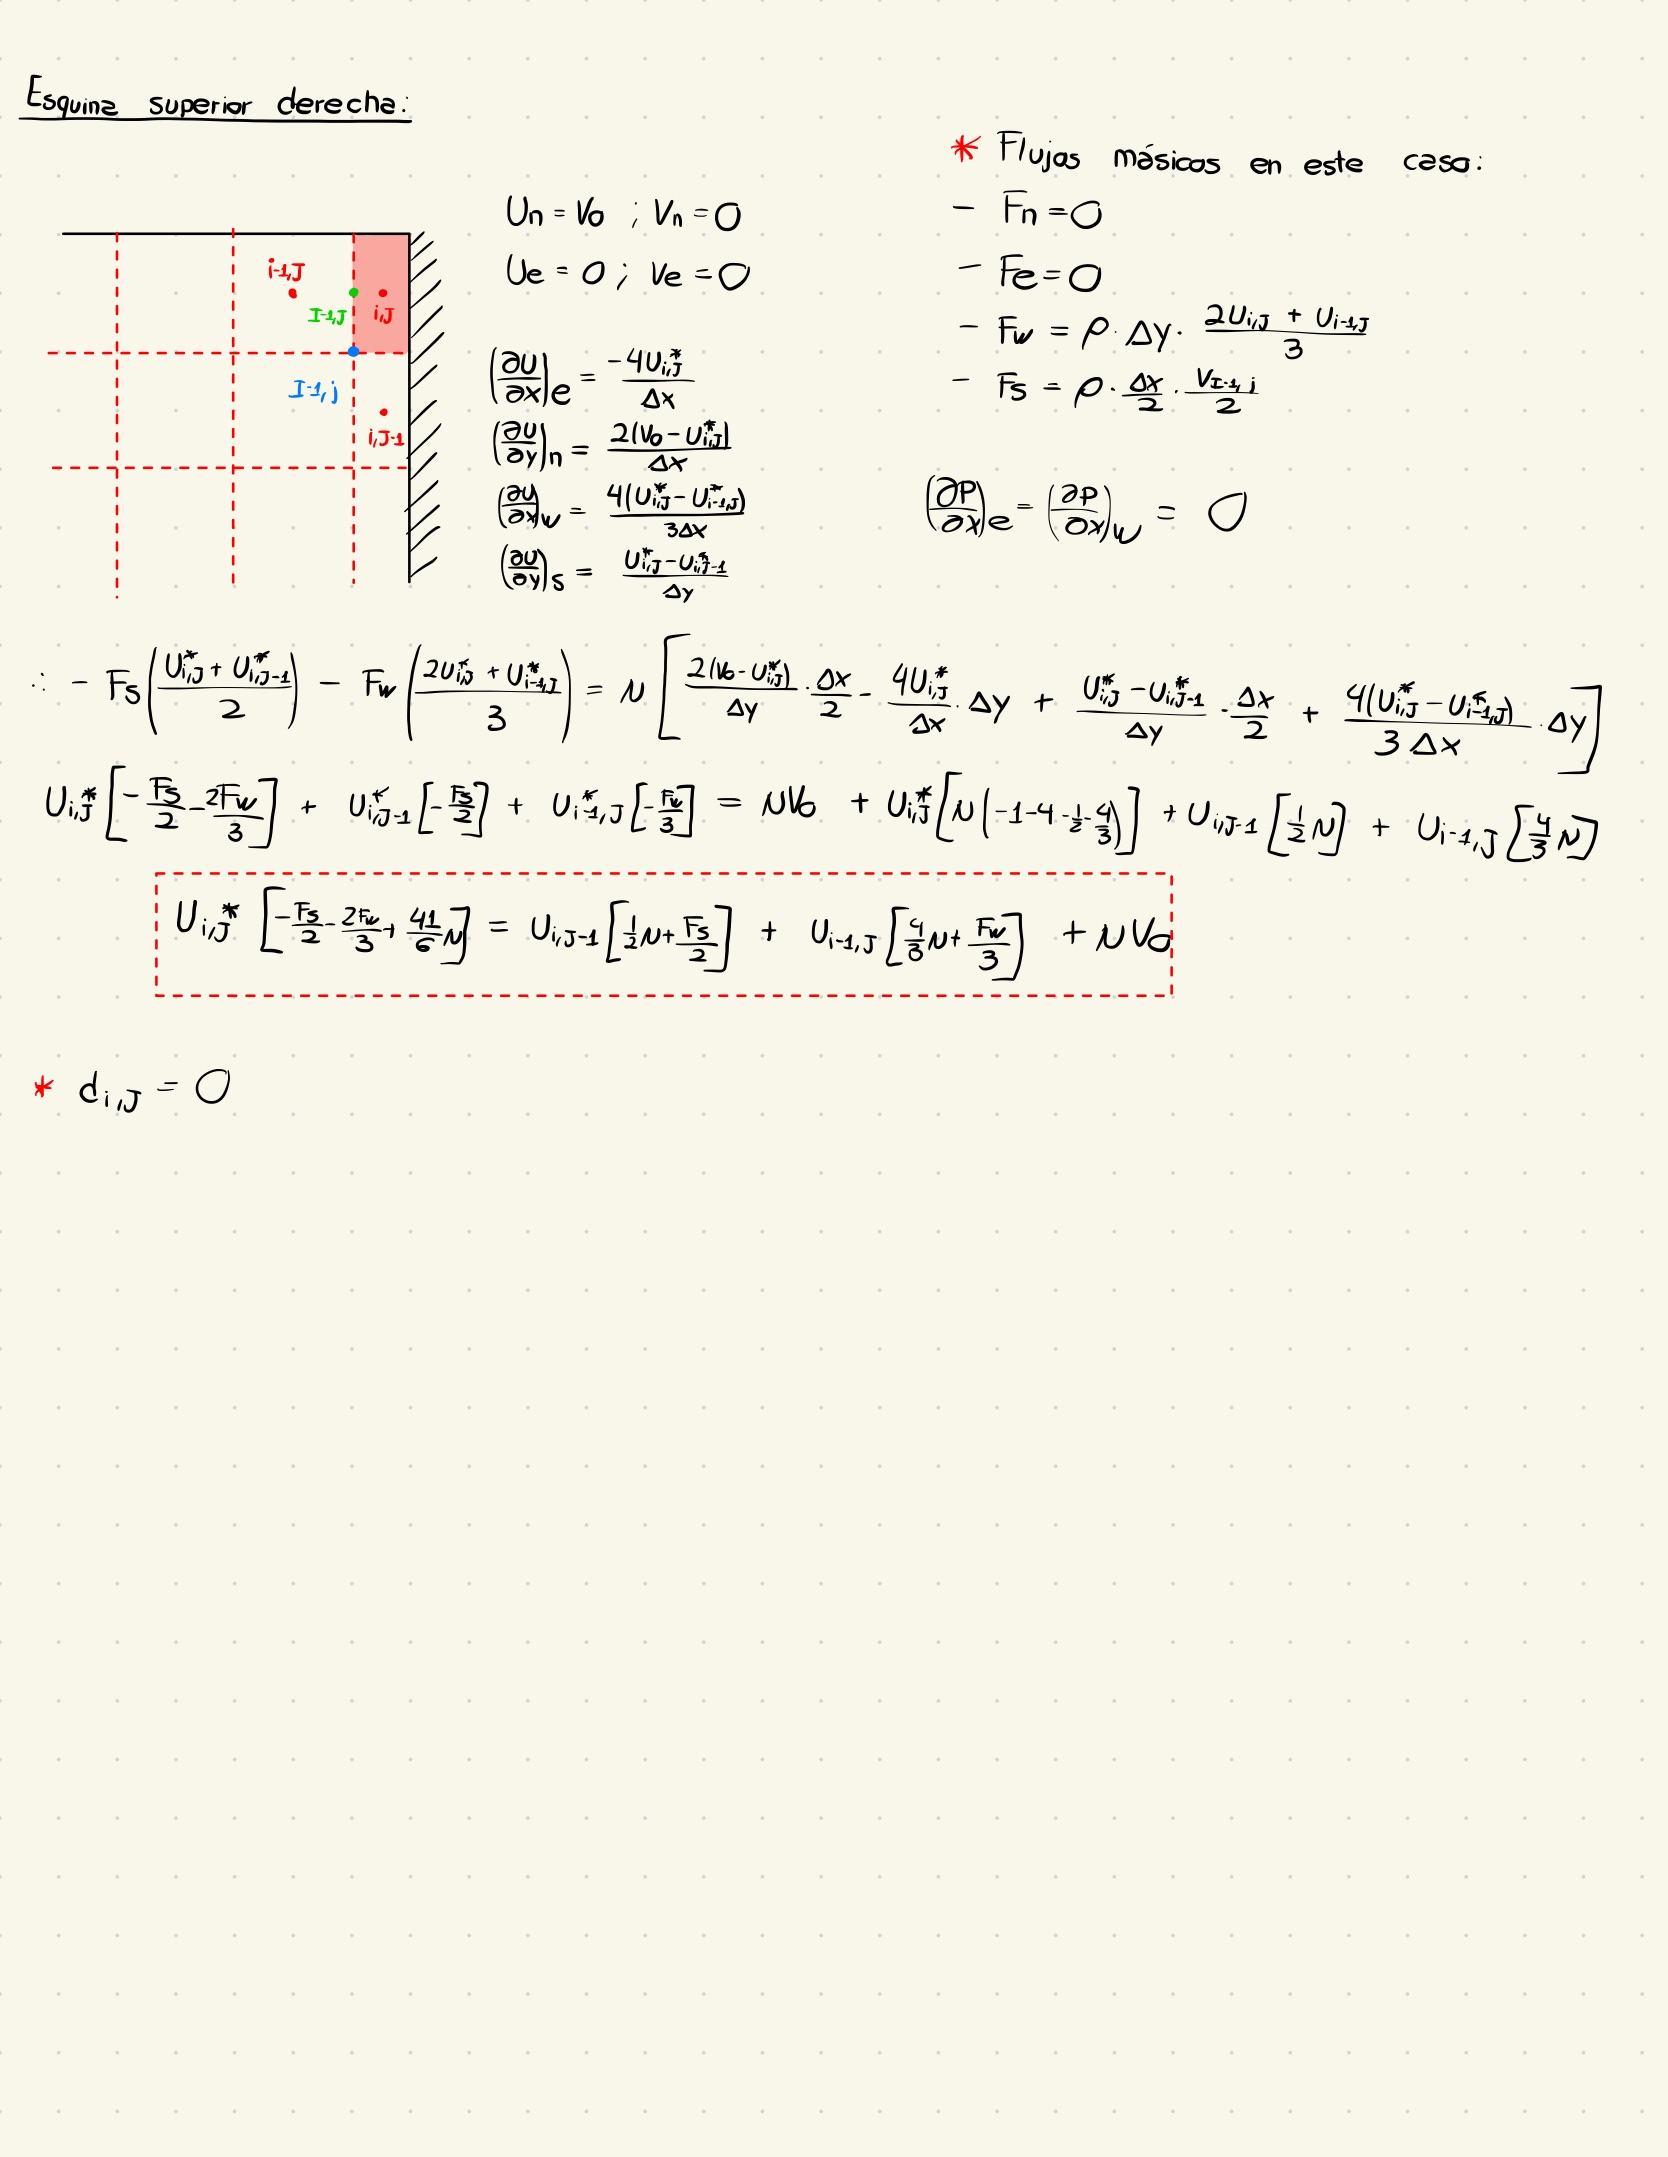
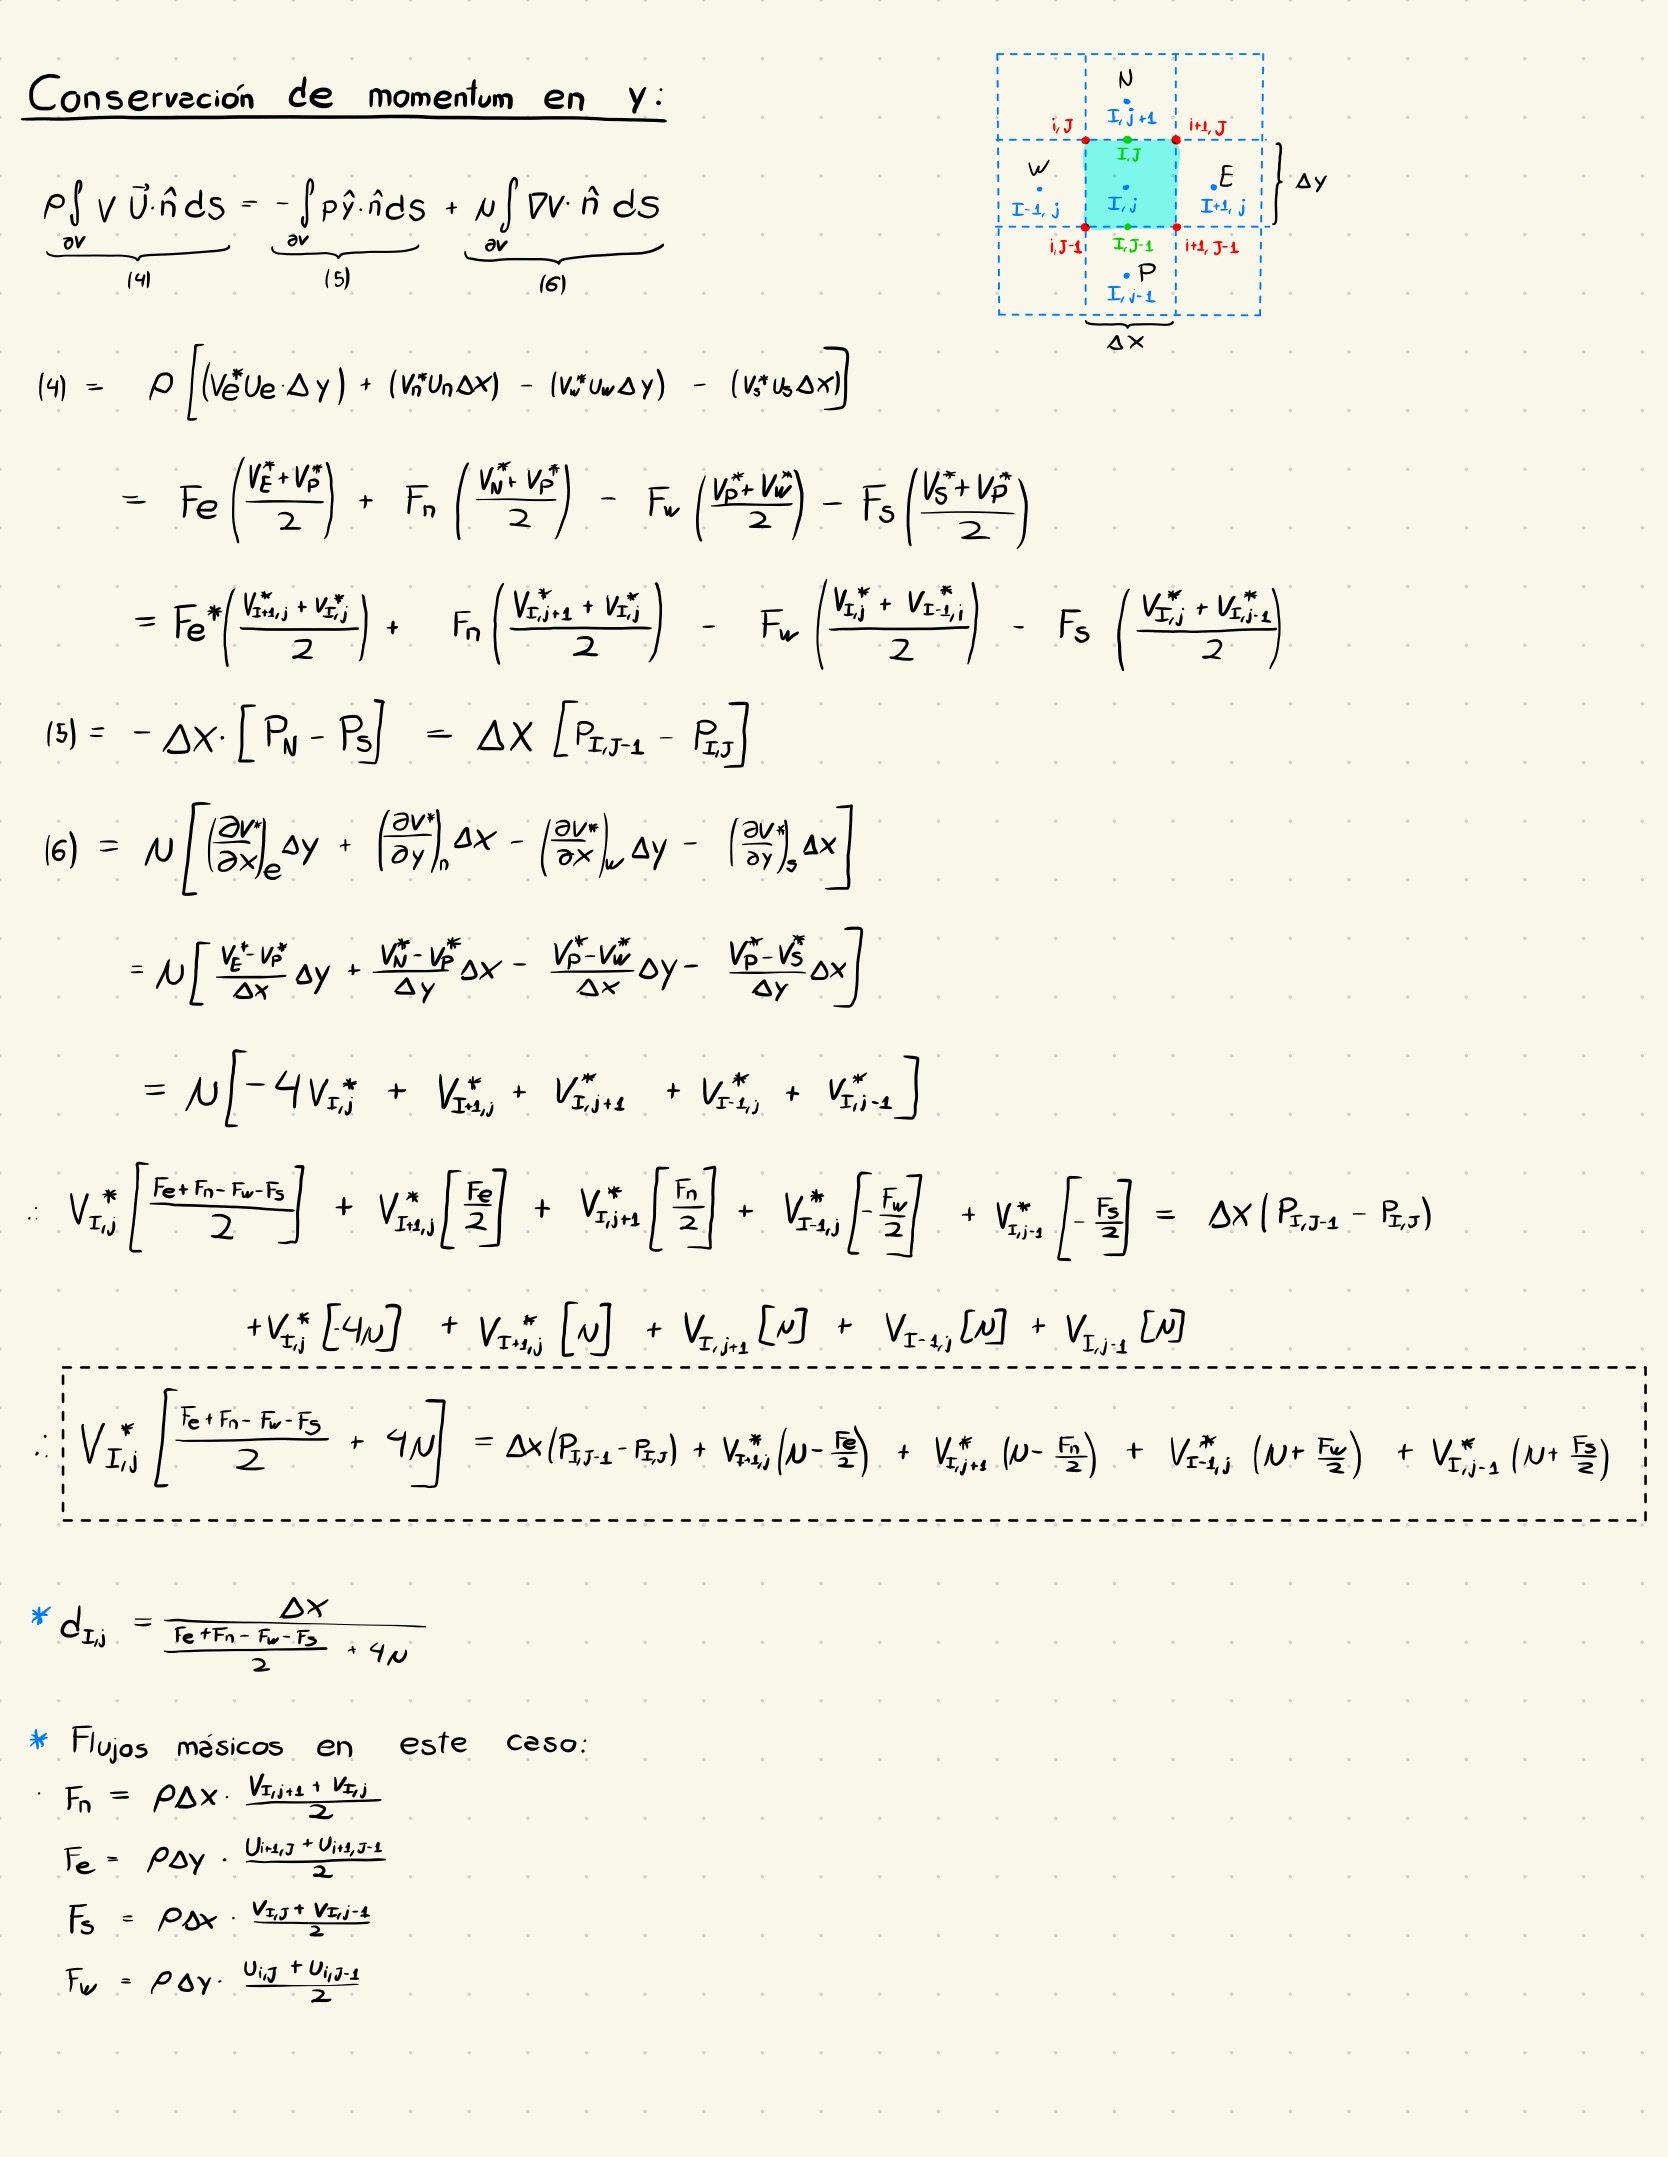
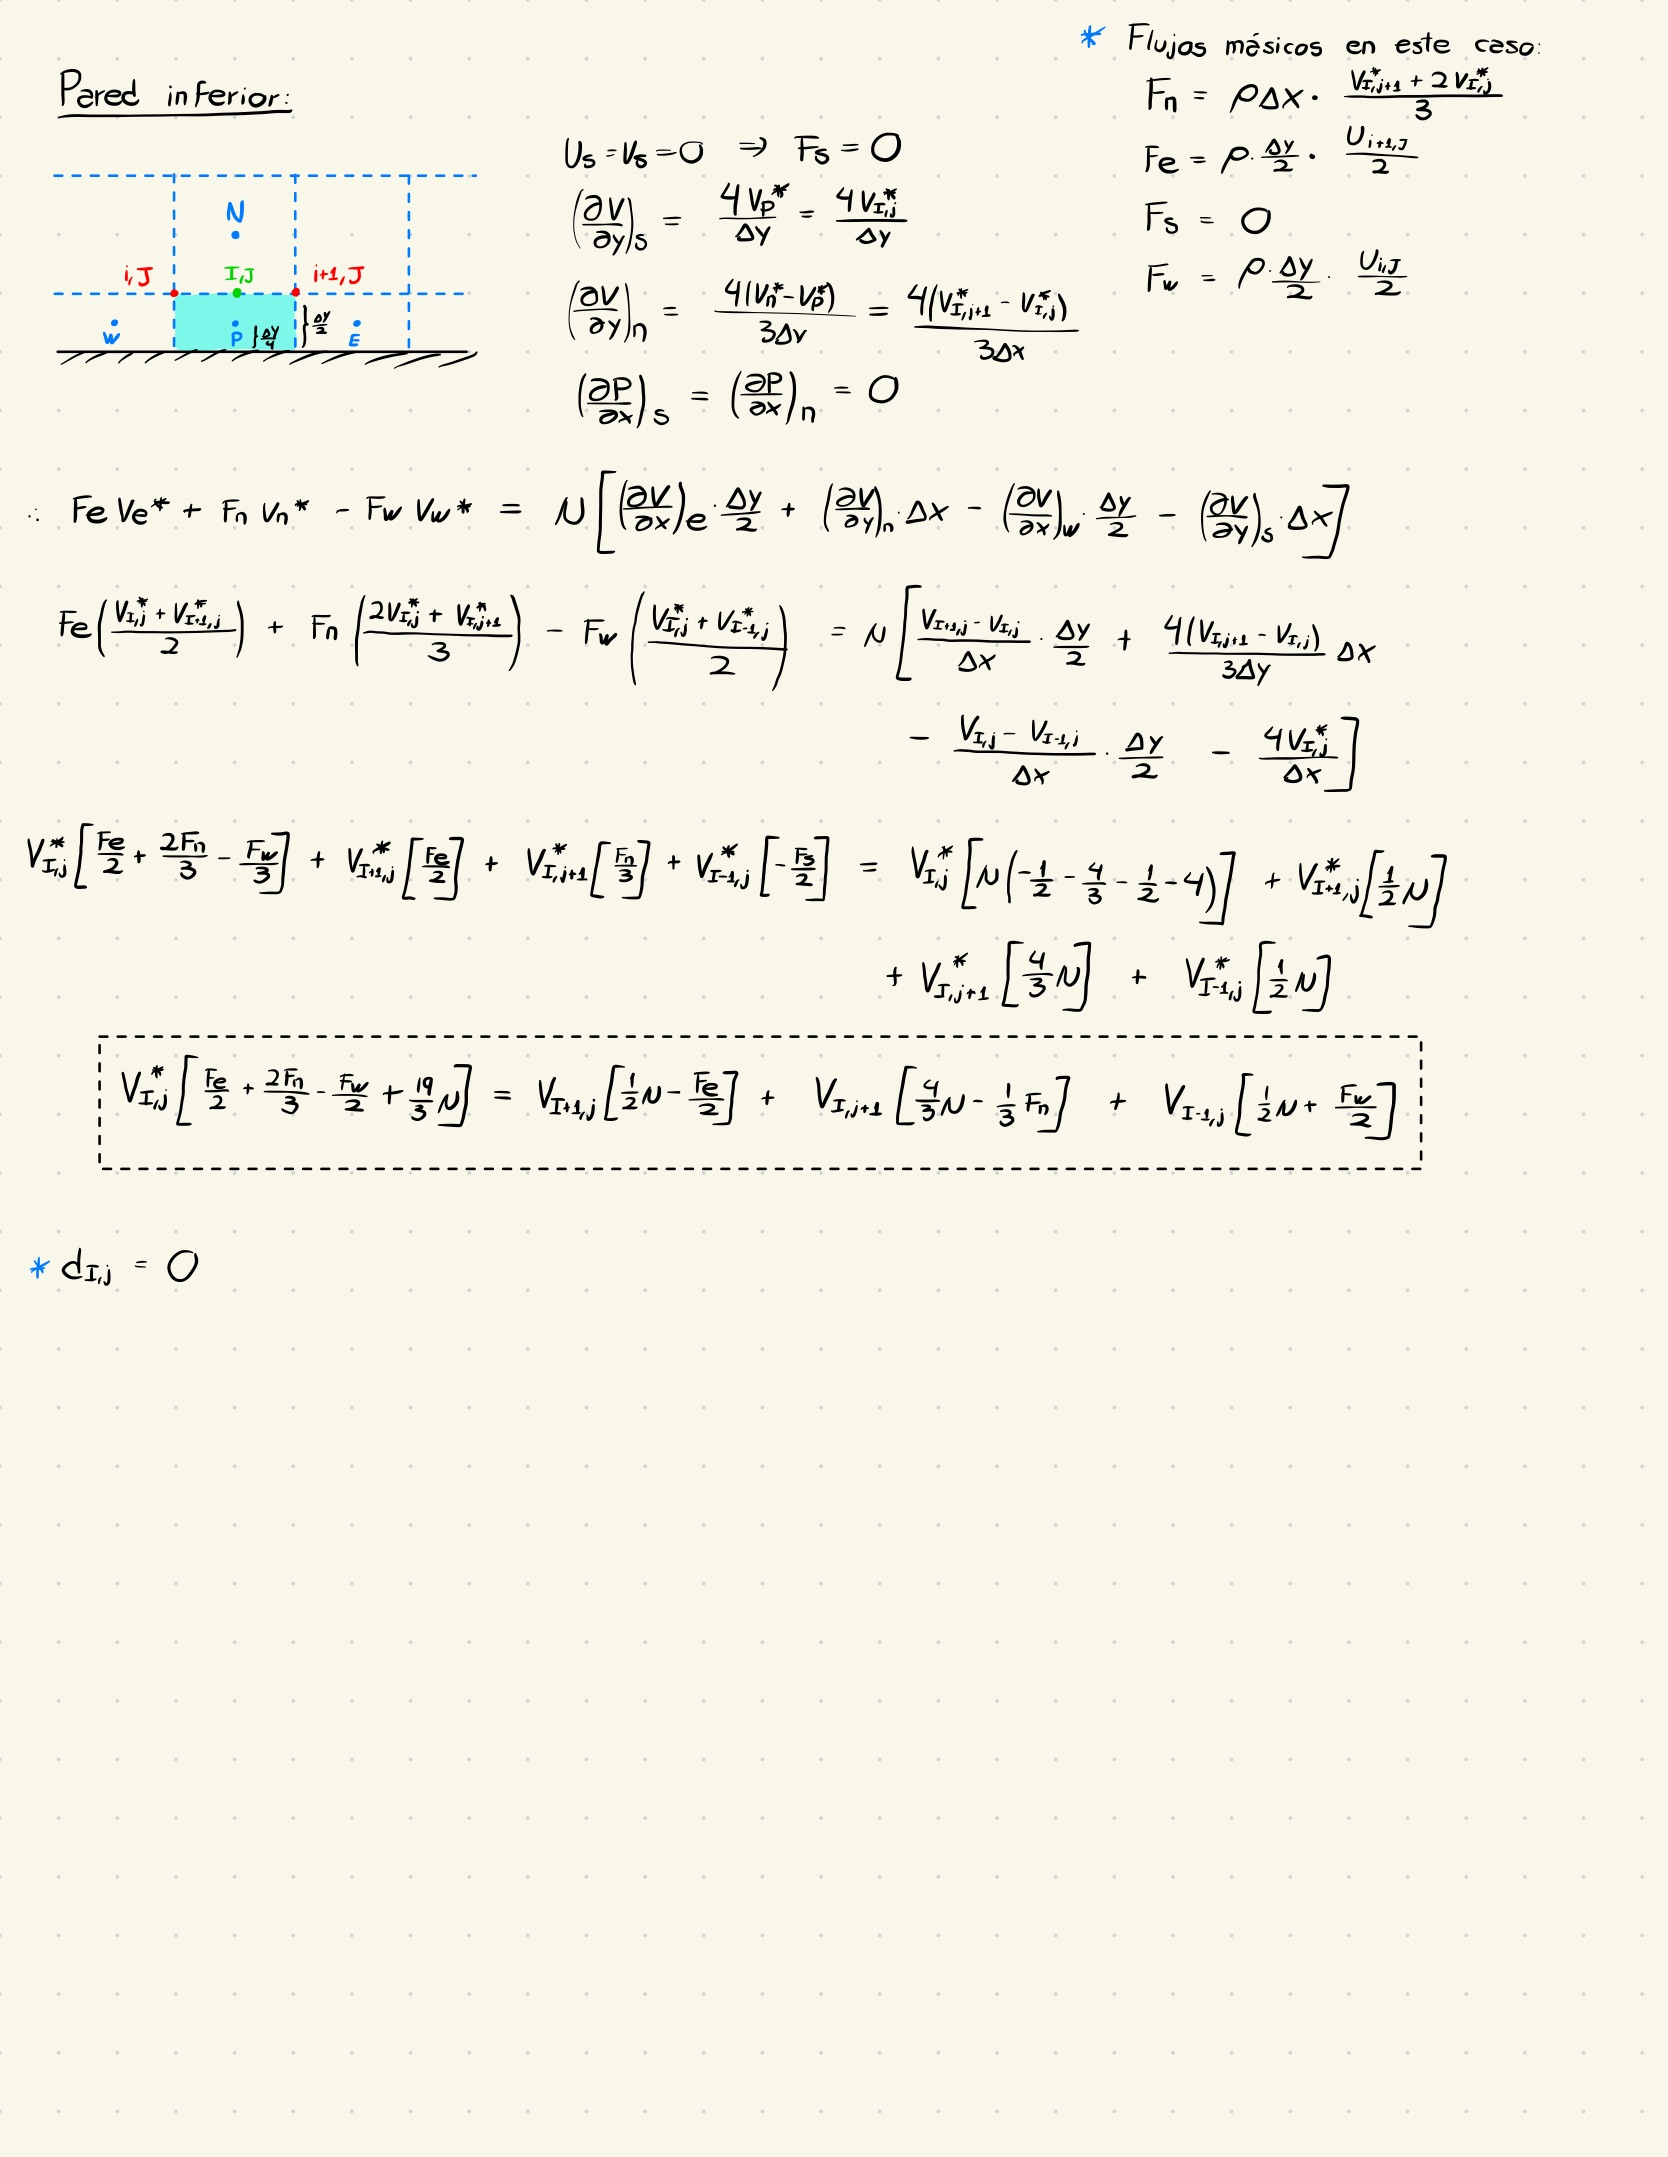
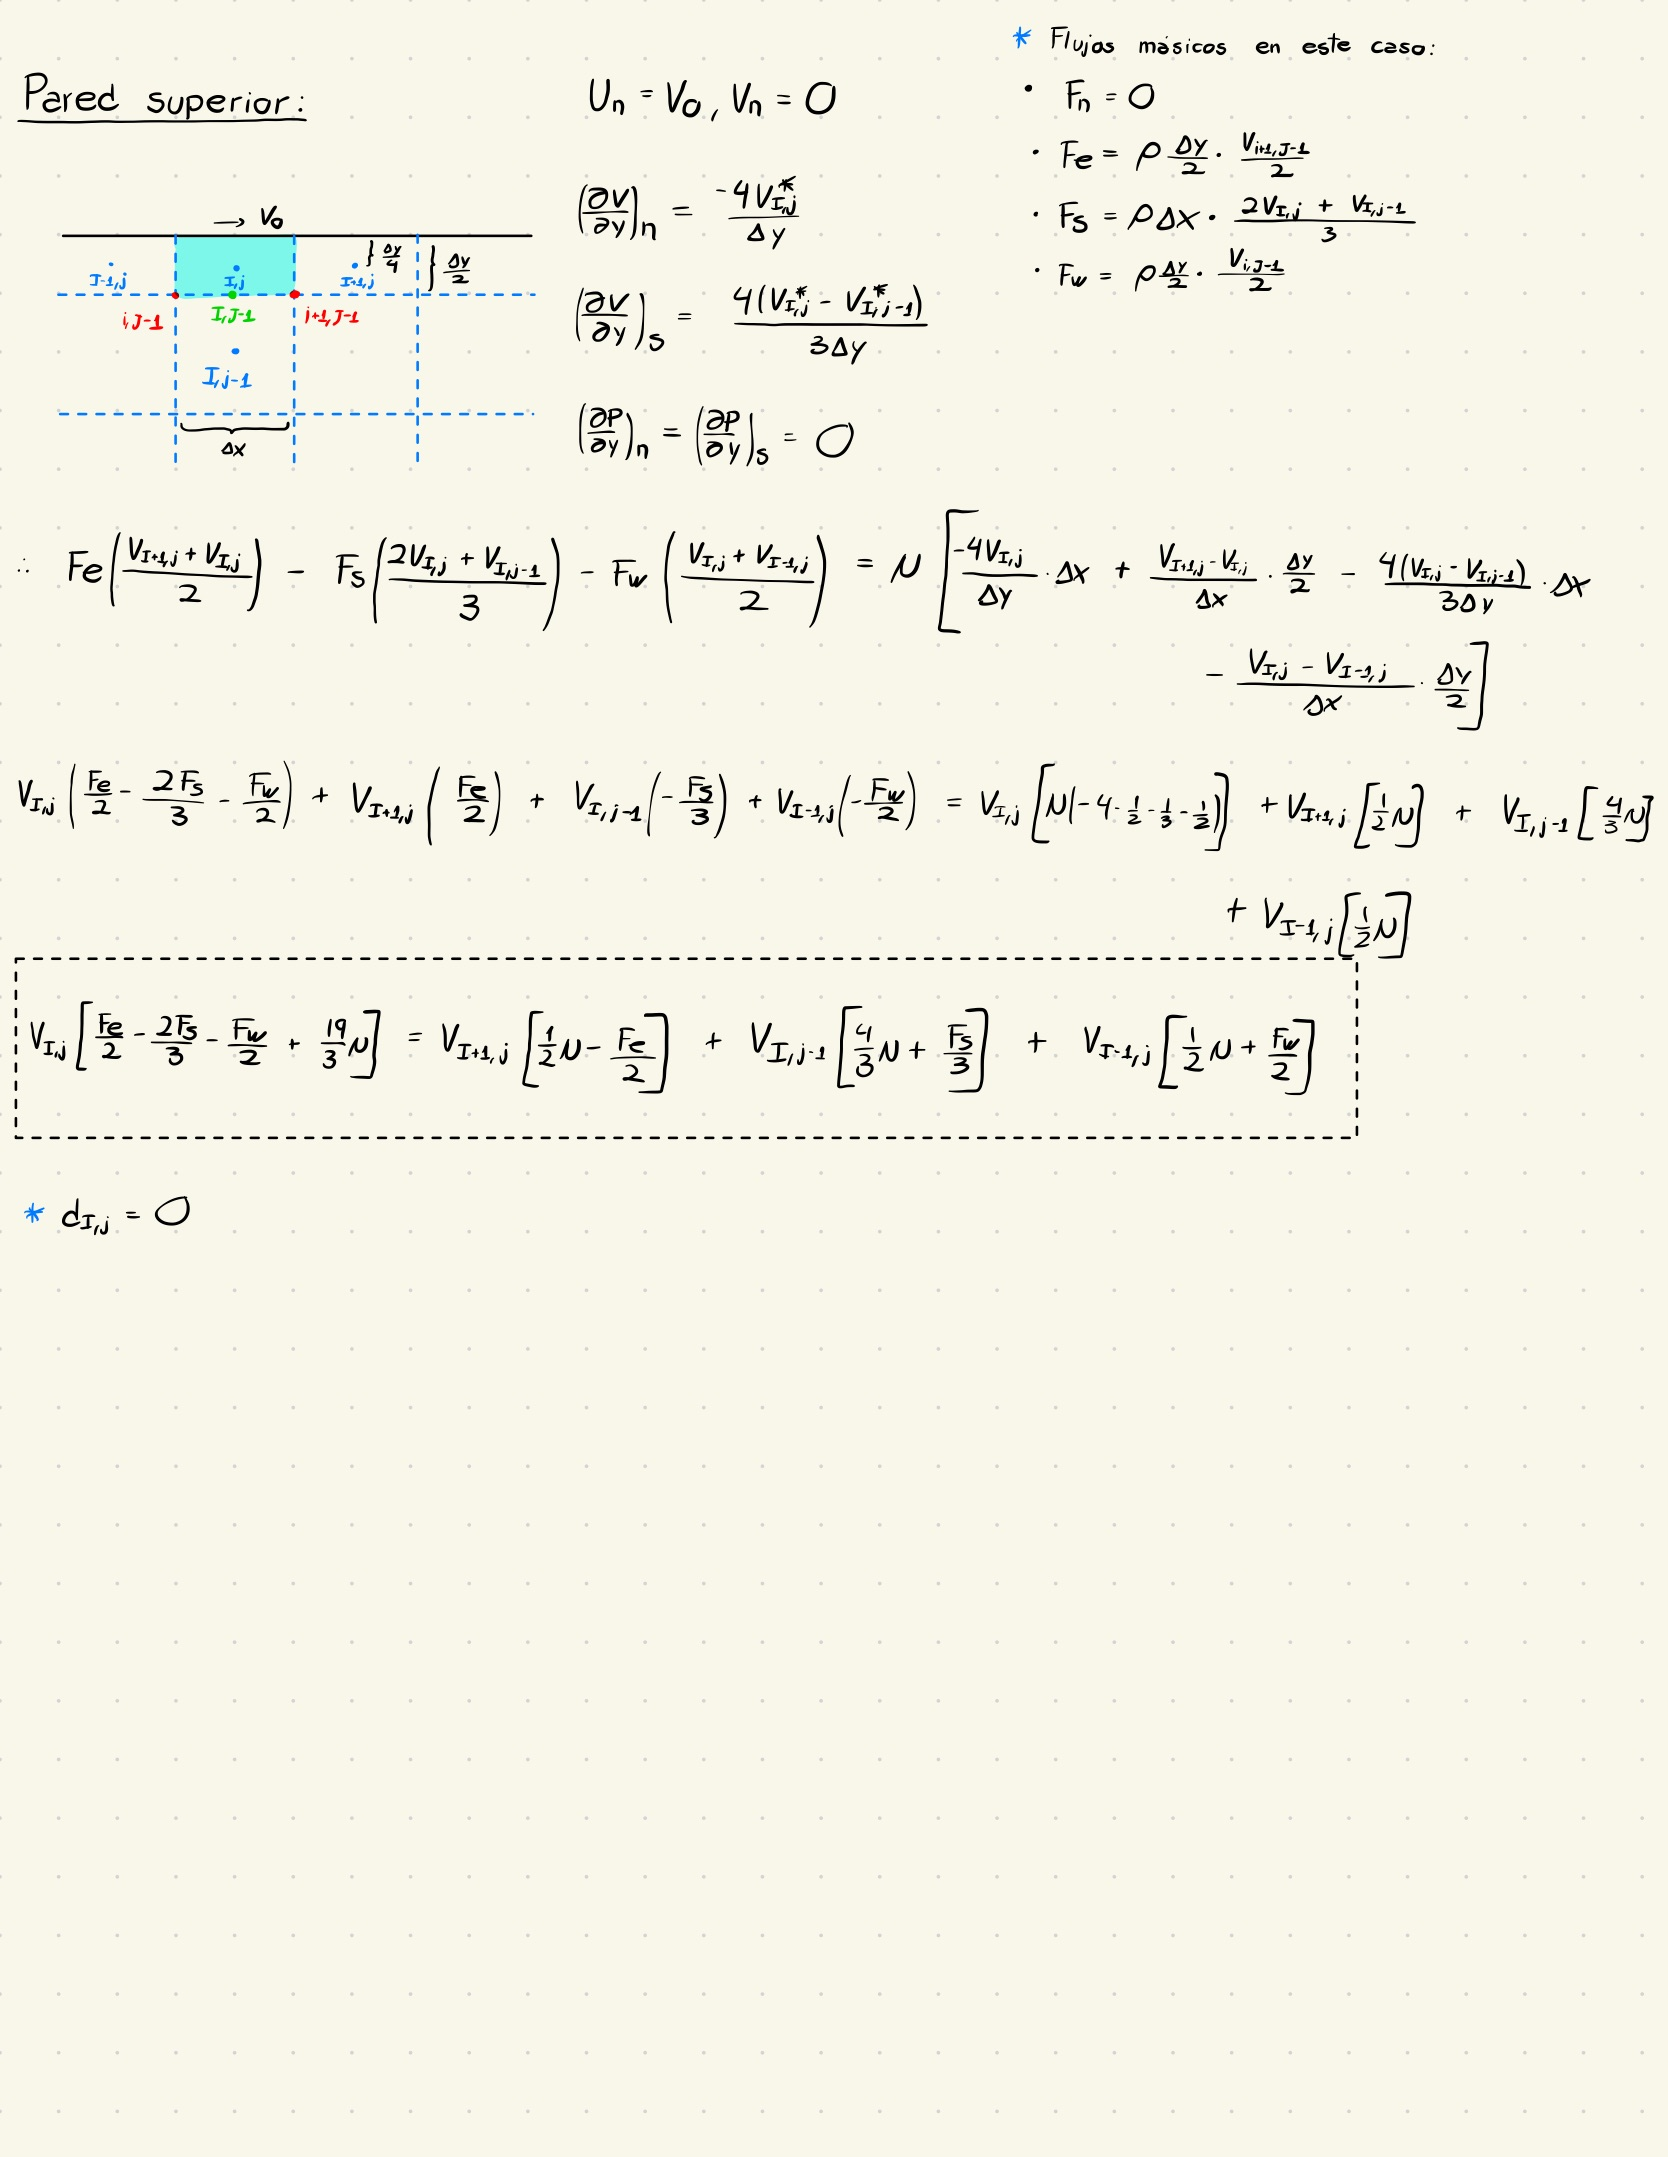
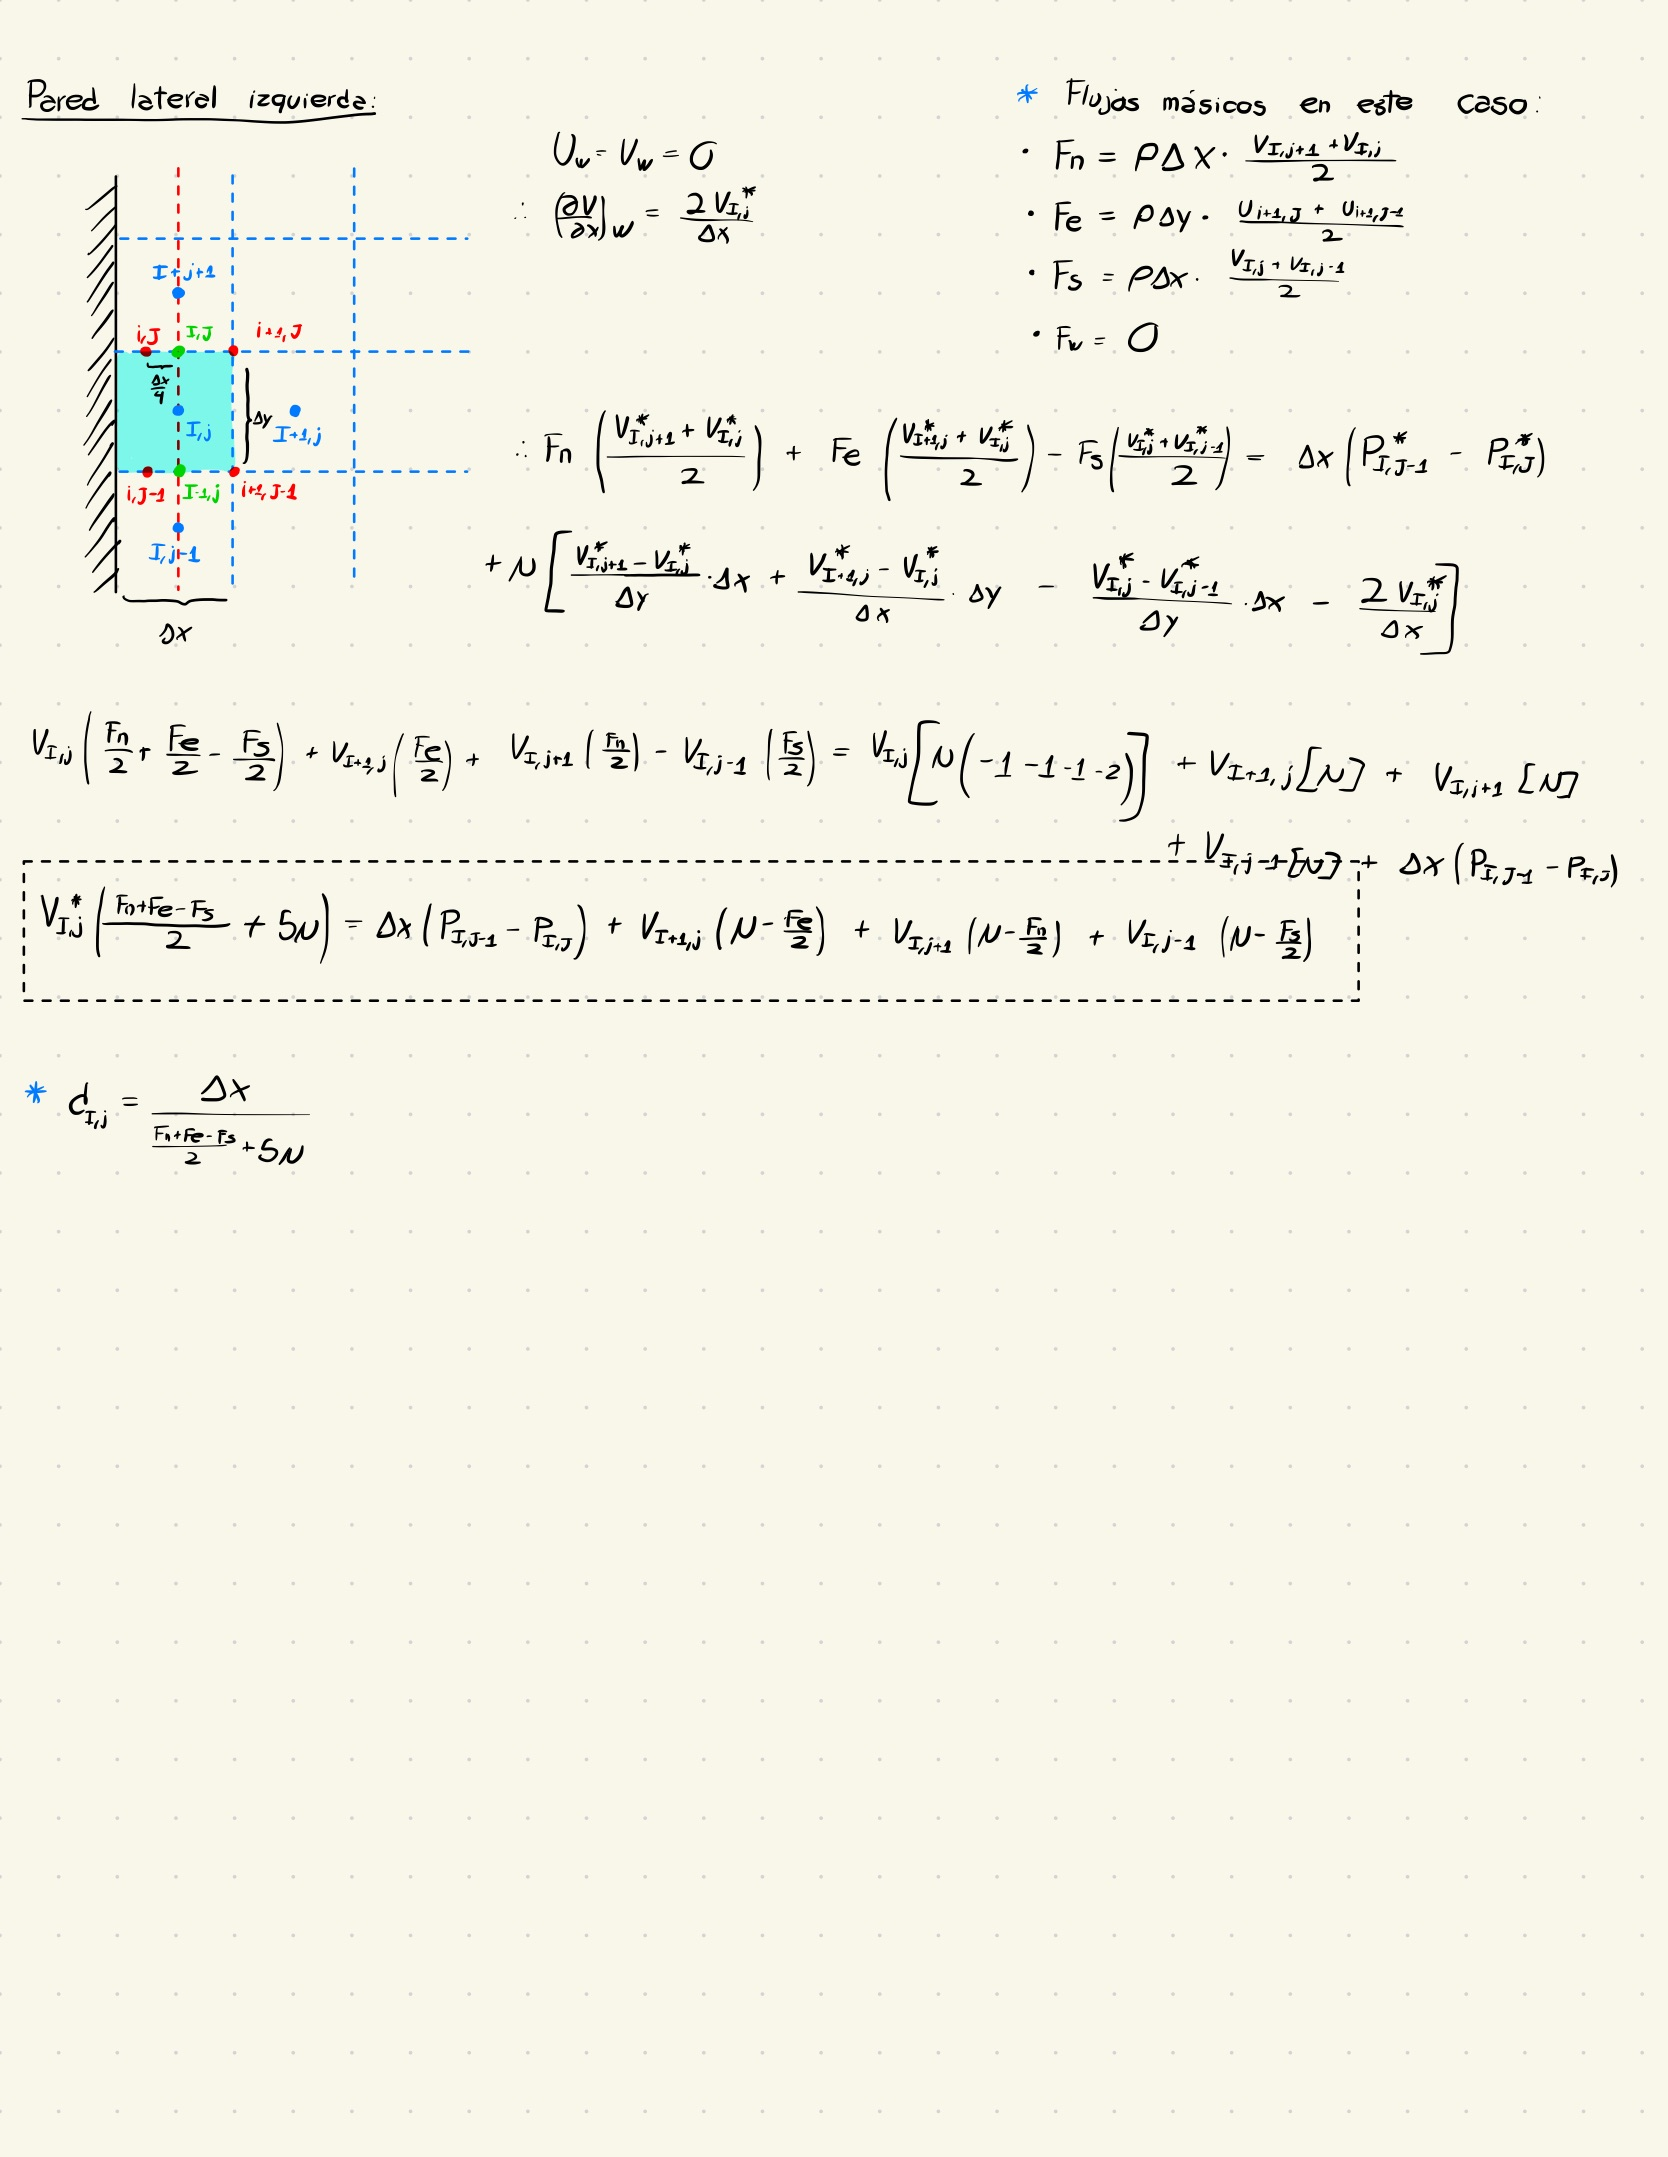
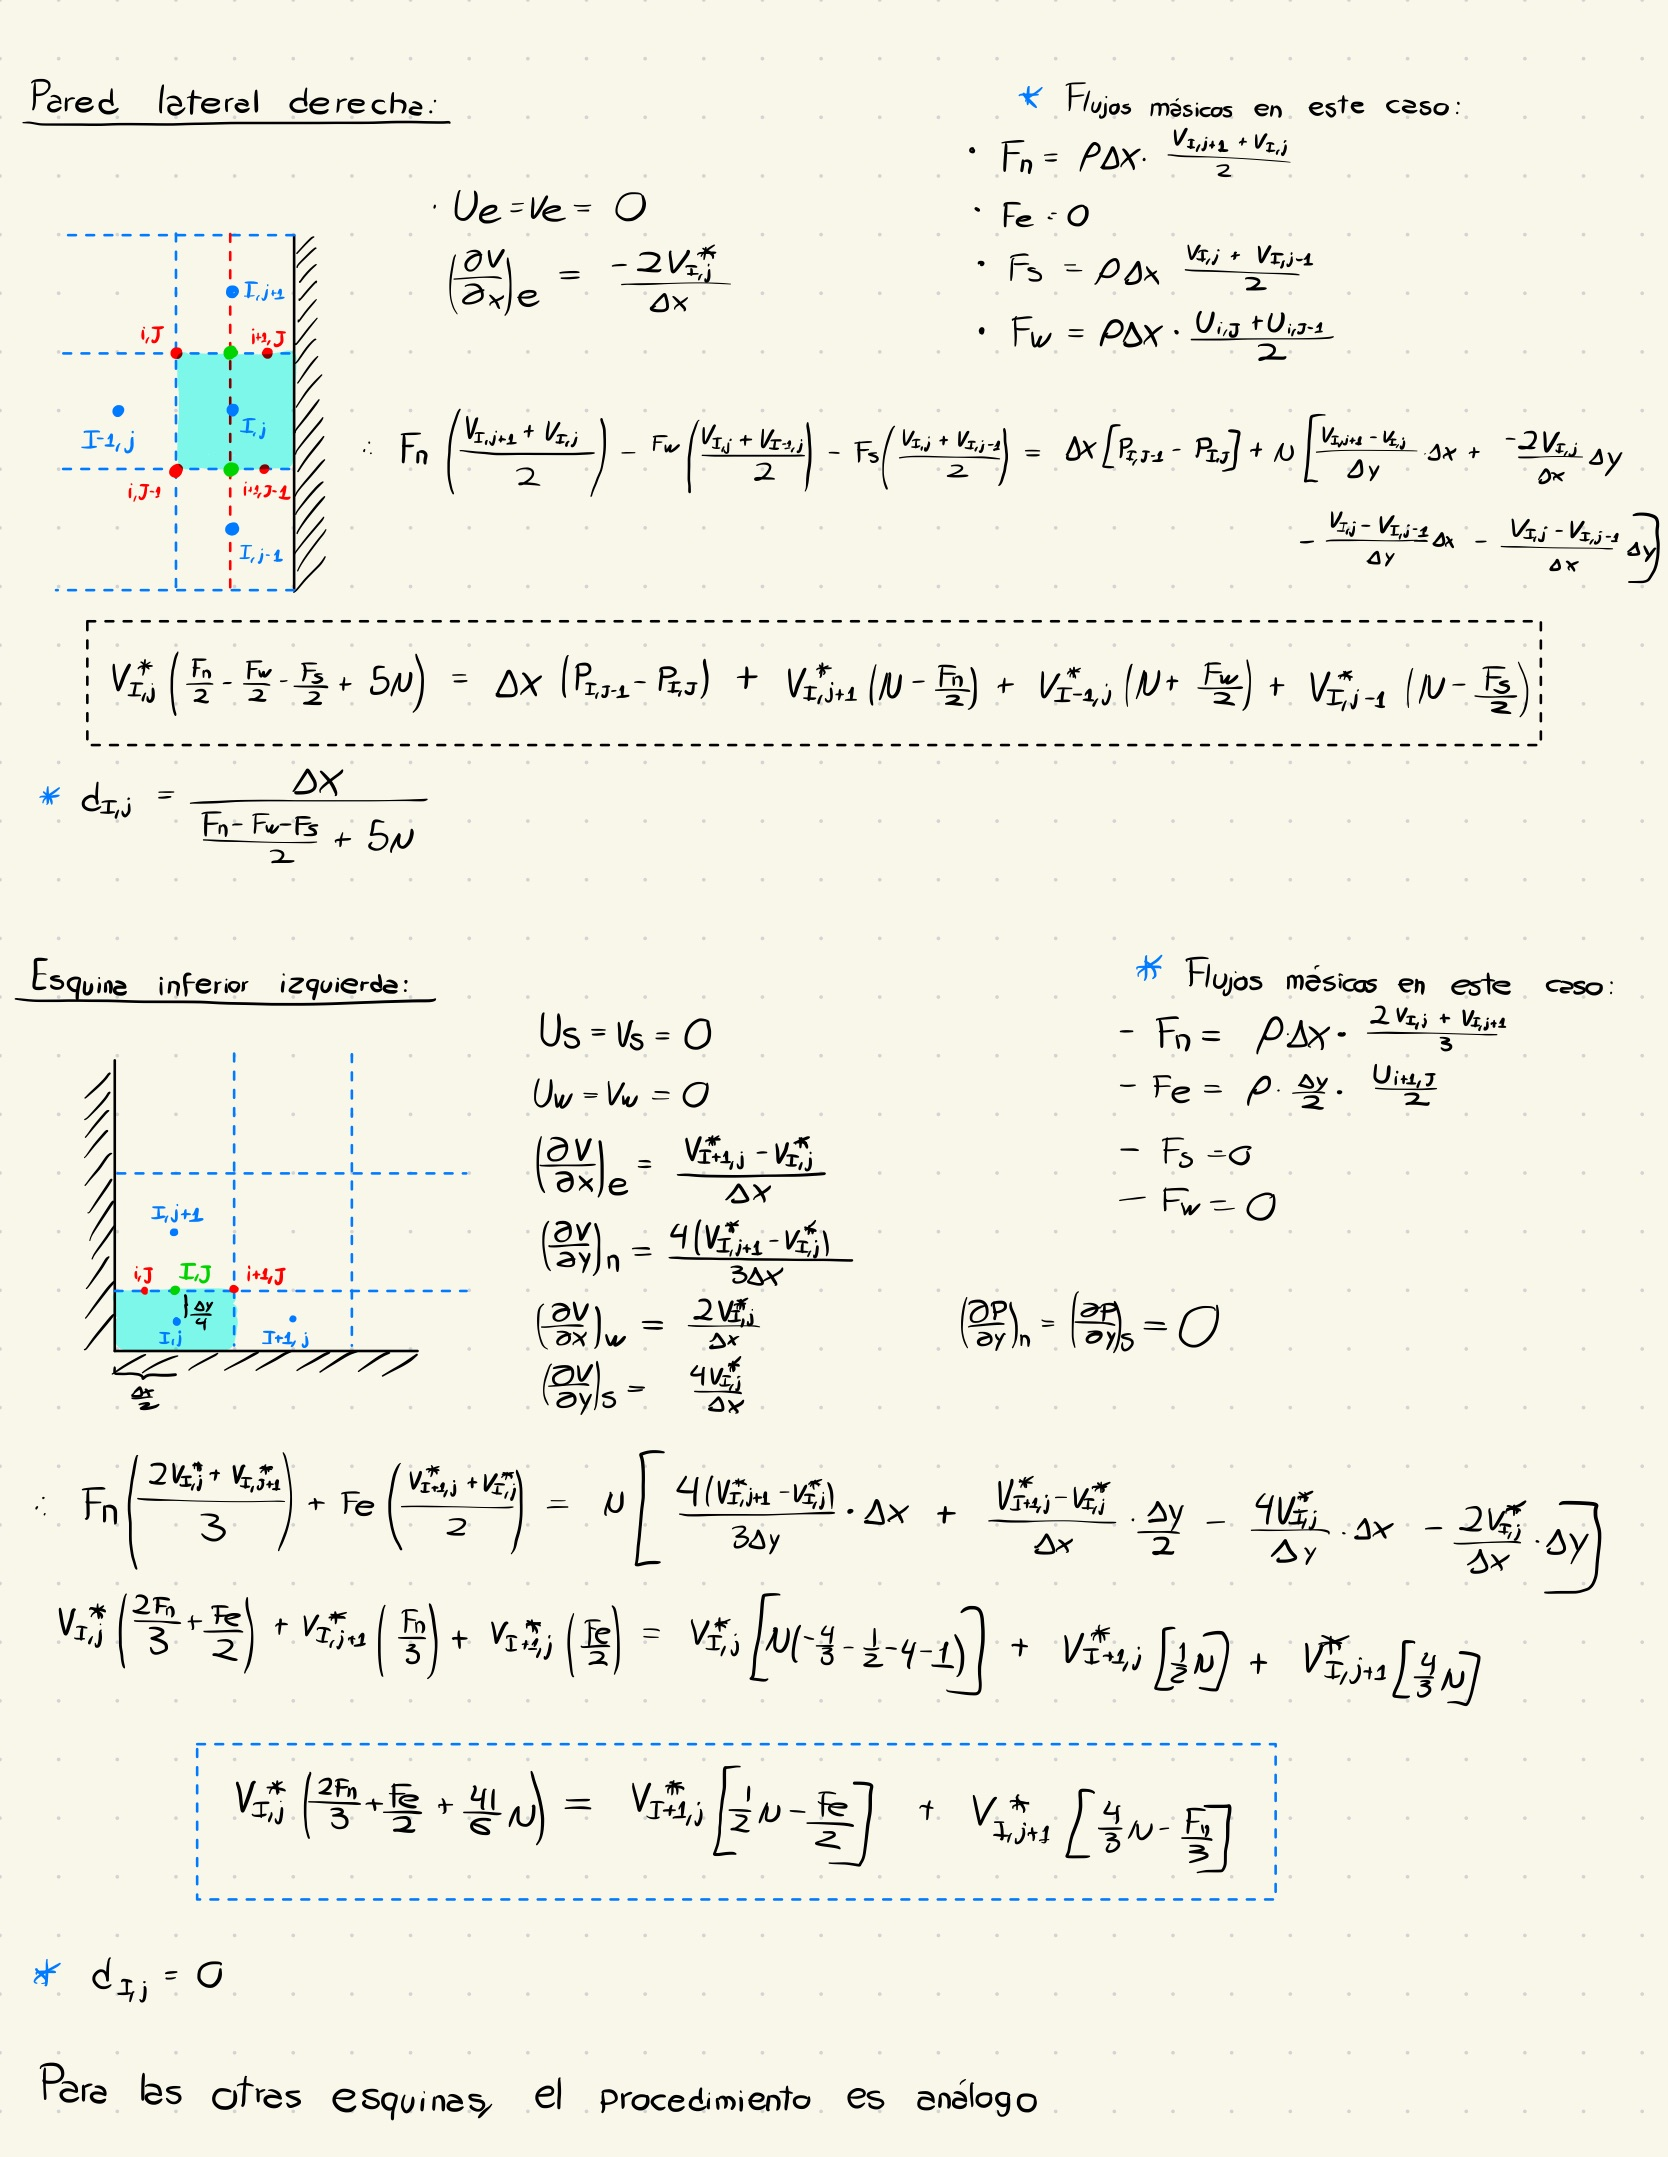
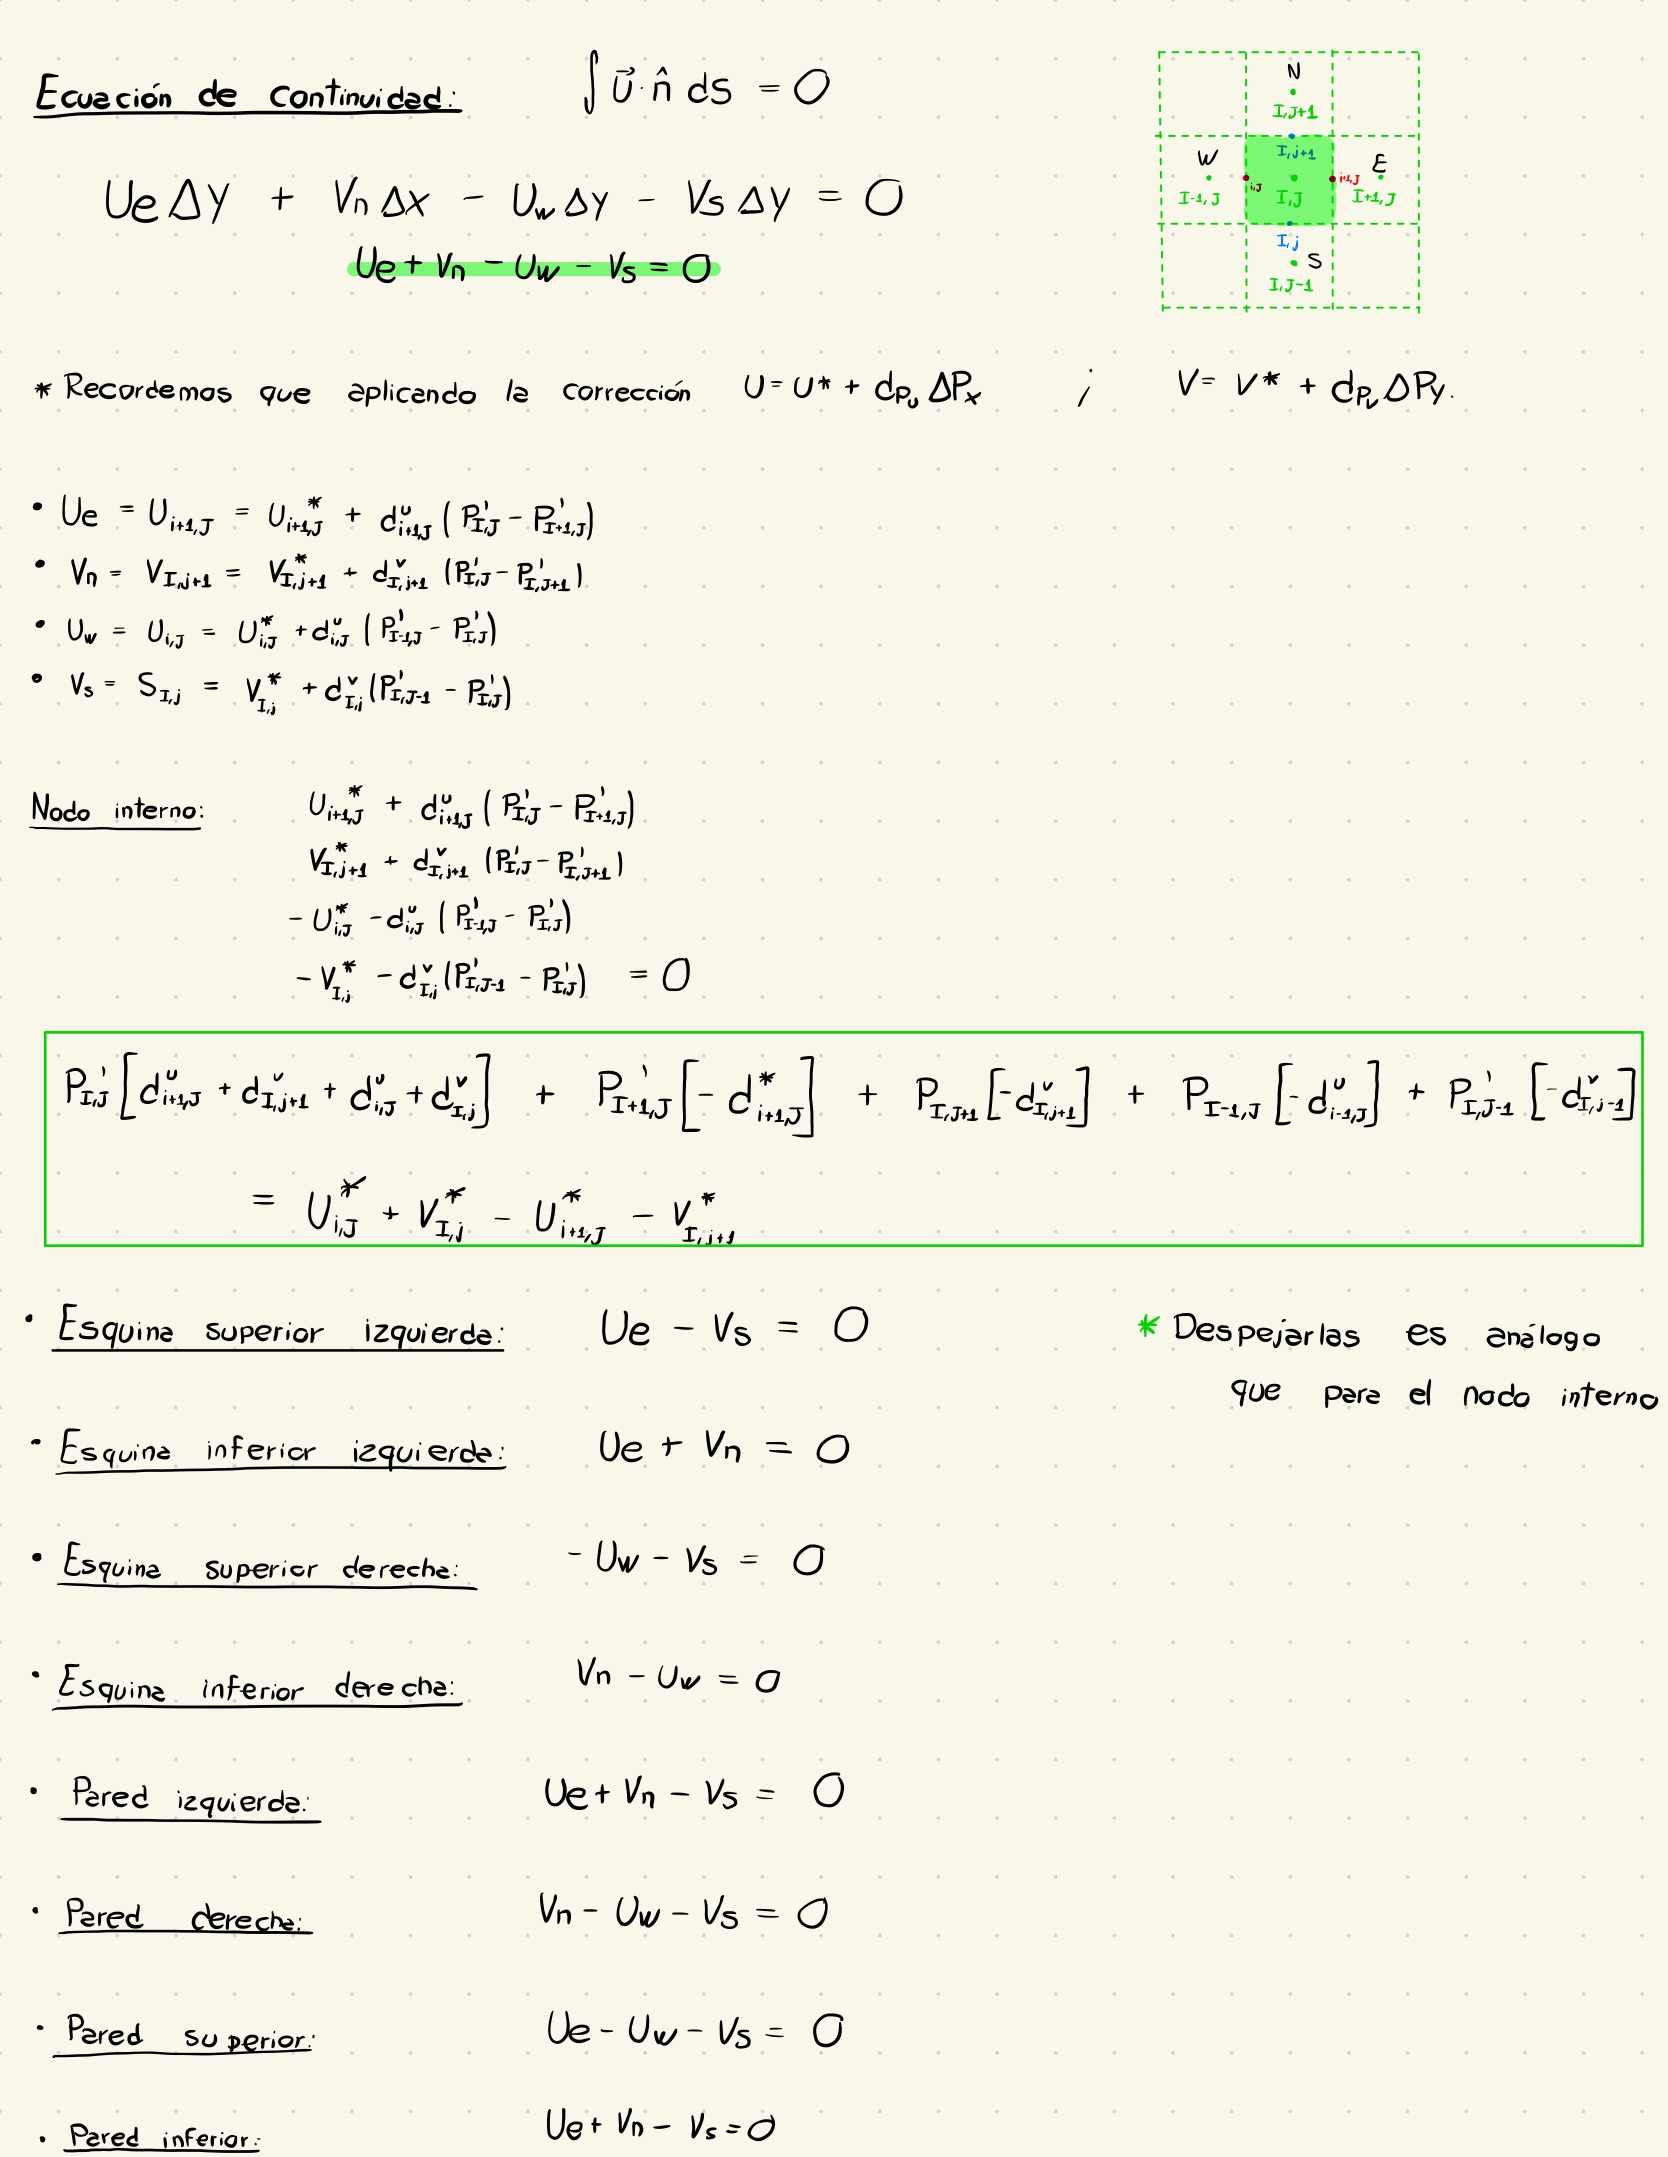

## Código implementado

Se crea una clase llamada Cavity_SIMPLE, la cual recibe el largo de la cavidad y el número de nodos. Dentro de esta clase se encuentran los siguientes métodos:

- `__init__`: Se inicializan las principales variables como la viscosidad, densidad y constantes de relajación
- `generar_malla_u`: Genera la malla para $u$ y define el $u$ con el que se empieza la iteración del algoritmo SIMPLE
- `generar_malla_v`: Genera la malla para $v$ y define el $v$ con el que se empieza la iteración del algoritmo SIMPLE
- `generar_malla_P`: Genera la malla para $P$ y define el $P$ con el que se empieza la iteración del algoritmo SIMPLE
- `plot_mallas`: Se grafican los nodos de cada malla y los volúmenes de control, como se mostró en el inicio del documento (personalmente para más de 12 nodos no recomiendo llamarla, no es tan claro el gráfico para muchos nodos)
- `u_momentum_equation`: Se plantea la ecuación de conservación de momentum en el eje $x$ para todos los nodos para despejar $u^*$
- `v_momentum_equation`: Se plantea la ecuación de conservación de momentum en el eje $y$ para todos los nodos para despejar $v^*$
- `corregir_valores`: Se corrigen los valores para la siguiente iteración considerando los factores de relajación
- `plot_velocity`: Grafica la magnitud de la velocidad dentro de la cavidad y lo compara con la solución obtenida en icoFoam (solver de simulaciones transientes laminares e incompresibles)
- `SIMPLE_algorithm`: Se arma el algoritmo SIMPLE llamando a los métodos necesarios 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [20]:
def isclose(a, b, tol=1e-2):
    return abs(a - b) < tol

**Nota** Cambié la viscosidad a $\mu = 1$ $[Pa\cdot s]$ en vez de $\mu = 0.01$ $[Pa\cdot s]$. Le pregunté al profesor y me dijo que mientras convergiera estaba bien, y que lo justificara basándome en imponer un cierto número de Reynolds $Re = \frac{\rho v_0 L}{\mu}$

In [21]:
class Cavity_SIMPLE:

    def __init__(self, L, N):
        self.L = L  # Longitud del dominio
        self.N = N  # Número de nodos
        self.mu = 1 # Viscosidad dinámica
        self.rho = 1.0 # Densidad
        self.v0 = 1 # Velocidad en la tapa superior
        self.h = L / (N - 1)  # Altura del dominio (asumiendo cuadrado)
        self.alpha_p = 10 * (10 ** (-1 * (self.N // 10)))  # Factor de relajación para presión
        self.alpha_u = self.alpha_p  # Factor de relajación para velocidad u
        self.alpha_v = self.alpha_p  # Factor de relajación para velocidad v

        self.SIMPLE_algorithm()

    def generar_malla_u(self):
        ''' Genera la malla para la velocidad u (velocidad horizontal) '''

        # --- 1. Definición del Eje X (Tu lógica original) ---
        # L = (N-1) * dx  -> dx se calcula así para ajustar los medios pasos
        dx = self.L / (self.N - 1)
        
        x_faces = np.zeros(self.N + 1)
        x_faces[0] = 0
        x_faces[-1] = self.L
        # Caras internas de X
        x_faces[1:-1] = (dx / 2) + np.arange(self.N - 1) * dx
        x_centers = (x_faces[:-1] + x_faces[1:]) / 2
        
        # --- 2. Definición del Eje Y (Uniforme) ---
        # Queremos que la altura sea aprox dx.
        # Dado que L = (N-1)*dx en el eje X, si usamos N-1 celdas en Y,
        # tendremos dy = L / (N-1) = dx. ¡Serán cuadrados perfectos!
        
        # Número de bordes en Y para tener celdas de tamaño dx
        num_celdas_y = self.N - 1
        
        # Linspace simple para dividir L en celdas iguales
        y_faces = np.linspace(0, self.L, num_celdas_y + 1)
        y_centers = (y_faces[:-1] + y_faces[1:]) / 2
        
        # Calculamos el dy real para confirmación
        dy = y_faces[1] - y_faces[0]

        self.X_u_nodes, self.Y_u_nodes = np.meshgrid(x_centers, y_centers)

        self.U_nodes_coordinates = np.column_stack((self.X_u_nodes.ravel(), self.Y_u_nodes.ravel()))

        self.U = np.zeros(len(self.U_nodes_coordinates)) * self.v0

        self.u_x_faces = x_faces
        self.u_y_faces = y_faces

    def generar_malla_v(self):
        ''' Genera la malla para la velocidad v (velocidad vertical) '''
        # 1. Definimos el paso base delta (dy) usando la lógica FVM en Y
        # L = (N-2)*dy + 2*(dy/2) => L = (N-1)*dy
        dy = self.L / (self.N - 1)
        dx = dy # Queremos celdas cuadradas en el interior
        
        # --- Eje Y (Refinado en bordes) ---
        y_faces = np.zeros(self.N + 1)
        y_faces[0] = 0
        y_faces[-1] = self.L
        # Caras internas empiezan en dy/2
        y_faces[1:-1] = (dy / 2) + np.arange(self.N - 1) * dy
        y_centers = (y_faces[:-1] + y_faces[1:]) / 2
        
        # --- Eje X (Uniforme estándar) ---
        # Si L es múltiplo exacto de dx (lo es por definición arriba), usamos linspace.
        # Necesitamos N caras en X para tener N-1 celdas de ancho dx
        x_faces = np.linspace(0, self.L, self.N)
        x_centers = (x_faces[:-1] + x_faces[1:]) / 2

        self.X_v_nodes, self.Y_v_nodes = np.meshgrid(x_centers, y_centers)

        self.V_nodes_coordinates = np.column_stack((self.X_v_nodes.ravel(order='C'), self.Y_v_nodes.ravel(order='C')))

        self.V = np.zeros(len(self.V_nodes_coordinates))

        self.v_x_faces = x_faces
        self.v_y_faces = y_faces   

    def generar_malla_P(self):
        ''' Genera la malla para la presión P
        (malla desplazada en delta_x/2 con respecto a malla u) '''

        # --- 1. Malla Original (Scalar/Presión) ---
        dx = self.L / (self.N - 1)
        
        x_faces_scalar = np.zeros(self.N + 1)
        x_faces_scalar[0] = 0
        x_faces_scalar[-1] = self.L
        x_faces_scalar[1:-1] = (dx / 2) + np.arange(self.N - 1) * dx
        
        x_centers_scalar = (x_faces_scalar[:-1] + x_faces_scalar[1:]) / 2
        
        # --- 2. Malla Desplazada (Velocidad u) ---
        # La lógica de desplazamiento delta_x/2 implica que los nodos 
        # se mueven a las caras.
        
        # Los nuevos nodos son las caras internas de la malla original
        # (Excluimos 0 y L porque suelen ser condiciones de contorno fijas)
        x_centers_staggered = x_faces_scalar[1:-1]
        
        # Los nuevos bordes (faces) son los centros de la malla original
        # Esto define el volumen de control alrededor de la cara
        x_faces_staggered = x_centers_scalar

        y_faces = np.linspace(0, self.L, self.N) # N caras para N-1 celdas cuadradas
        y_centers = (y_faces[:-1] + y_faces[1:]) / 2        

        self.X_P_nodes, self.Y_P_nodes = np.meshgrid(x_centers_staggered, y_centers)
 
        self.P_nodes_coordinates = np.column_stack((self.X_P_nodes.ravel(), self.Y_P_nodes.ravel()))

        self.P = np.zeros(len(self.P_nodes_coordinates))

        self.p_x_faces = x_faces_staggered
        self.p_y_faces = y_faces

    def plot_mallas(self):

        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        titles = ["Malla u (velocidad horizontal)", 
                "Malla v (velocidad vertical)", 
                "Malla P (presión)"]

        # ------------------------------
        # Función auxiliar para dibujar VC
        # ------------------------------
        def dibujar_volumenes(ax, x_faces, y_faces, color, alpha=0.15):
            for i in range(len(x_faces)-1):
                for j in range(len(y_faces)-1):
                    x0 = x_faces[i]
                    x1 = x_faces[i+1]
                    y0 = y_faces[j]
                    y1 = y_faces[j+1]

                    ax.add_patch(
                        plt.Rectangle(
                            (x0, y0),
                            x1 - x0,
                            y1 - y0,
                            edgecolor=color,
                            facecolor=color,
                            alpha=alpha,
                            linewidth=0.7
                        )
                    )

        # -------------------------------------------------------------
        # PLOT 1 — MALLA u
        # -------------------------------------------------------------
        ax = axes[0]
        ax.set_aspect("equal")
        ax.set_title(titles[0])

        dibujar_volumenes(ax, self.u_x_faces, self.u_y_faces, 'red', alpha=0.1)

        ax.scatter(self.X_u_nodes, self.Y_u_nodes, color='red', s=20)
        for i, (x, y) in enumerate(self.U_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='red', ha='center', va='bottom')

        ax.scatter(self.X_v_nodes, self.Y_v_nodes, color='blue', s=20)
        for i, (x, y) in enumerate(self.V_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='blue', ha='center', va='bottom')

        ax.scatter(self.X_P_nodes, self.Y_P_nodes, color='green', s=20)
        for i, (x, y) in enumerate(self.P_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='green', ha='center', va='bottom')

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        # ax.grid(True, linestyle="--", linewidth=0.4)

        # -------------------------------------------------------------
        # PLOT 2 — MALLA v
        # -------------------------------------------------------------
        ax = axes[1]
        ax.set_aspect("equal")
        ax.set_title(titles[1])

        dibujar_volumenes(ax, self.v_x_faces, self.v_y_faces, 'blue', alpha=0.1)

        ax.scatter(self.X_u_nodes, self.Y_u_nodes, color='red', s=20)
        for i, (x, y) in enumerate(self.U_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='red', ha='center', va='bottom')

        ax.scatter(self.X_v_nodes, self.Y_v_nodes, color='blue', s=20)
        for i, (x, y) in enumerate(self.V_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='blue', ha='center', va='bottom')

        ax.scatter(self.X_P_nodes, self.Y_P_nodes, color='green', s=20)
        for i, (x, y) in enumerate(self.P_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='green', ha='center', va='bottom')

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        # ax.grid(True, linestyle="--", linewidth=0.4)

        # -------------------------------------------------------------
        # PLOT 3 — MALLA P
        # -------------------------------------------------------------
        ax = axes[2]
        ax.set_aspect("equal")
        ax.set_title(titles[2])

        dibujar_volumenes(ax, self.p_x_faces, self.p_y_faces, 'green', alpha=0.1)

        ax.scatter(self.X_u_nodes, self.Y_u_nodes, color='red', s=20)
        for i, (x, y) in enumerate(self.U_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='red', ha='center', va='bottom')

        ax.scatter(self.X_v_nodes, self.Y_v_nodes, color='blue', s=20)
        for i, (x, y) in enumerate(self.V_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='blue', ha='center', va='bottom')

        ax.scatter(self.X_P_nodes, self.Y_P_nodes, color='green', s=20)
        for i, (x, y) in enumerate(self.P_nodes_coordinates):
            ax.text(x, y, str(i), fontsize=8, color='green', ha='center', va='bottom')

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        # ax.grid(True, linestyle="--", linewidth=0.4)

        plt.tight_layout()
        plt.show()

    def u_momentum_equations(self):
        ''' Genera las ecuaciones de momentum para la velocidad u '''
        A = np.zeros((len(self.U), len(self.U)))
        b = np.zeros(len(self.U))
        self.d_u_vector = np.zeros(len(self.U))

        for i in range(len(self.U)):
            # Índices para los nodos de U
            P = i
            E = i + 1
            W = i - 1
            N = i + (self.N)
            S = i - (self.N)
            
            # Índices para los nodos de v
            I_j = P - (P // (self.N))  #
            Imin1_j = I_j - 1
            I_jplus1 = P + (self.N - (P // (self.N))) - 1
            Imin1_jplus1 = I_jplus1 - 1

            # Índices para los nodos de P
            IJ = P - (P // (self.N))  # Nodo P correspondiente al nodo U actual
            Imin1_J = IJ - 1

            # Caso 1: Esquina inferior izquierda (P = 0):
            if isclose(P, 0):
                # print("Esquina inferior izquierda en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h/2 * (self.V[I_jplus1] / 2)
                F_e = self.rho * self.h * ((2 * self.U[P] + self.U[E]) / 3)
                F_s = 0  # Pared sólida
                F_w = 0  # Pared sólida

                A[P, P] = (F_n / 2) + (2*F_e / 3) + (41 * self.mu / 6)
                A[P, E] = - ((4 * self.mu) / 3 - (F_e / 3))
                A[P, N] = - ((self. mu / 2) - (F_n / 2))

            # Caso 2: Esquina superior izquierda (P = (N-1)*(N-1)):
            elif isclose(P, (self.N) * (self.N - 2)):
                # print("Esquina superior izquierda en P =", P)
                # Primero calculamos los flujos másicos
                F_n = 0  # Pared sólida
                F_e = self.rho * self.h * ((2 * self.U[P] + self.U[E]) / 3)
                F_s = self.rho * self.h/2 * (self.V[I_j] / 2)
                F_w = 0  # Pared sólida

                A[P, P] = (2*F_e / 3) - (F_s / 2) + (41 * self.mu / 6)
                A[P, E] = - ((4 * self.mu) / 3 - (F_e / 3))
                A[P, S] = - ((self. mu / 2) + (F_s / 2))
                b[P] = self.mu * self.v0

            # Caso 3: Esquina inferior derecha (P = N-1):
            elif isclose(P, self.N - 1):
                # print("Esquina inferior derecha en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h/2 * (self.V[Imin1_jplus1] / 2)
                F_e = 0  # Pared sólida
                F_s = 0  # Pared sólida
                F_w = self.rho * self.h * ((2* self.U[P] + self.U[W]) / 3)

                A[P, P] = (F_n / 2) - (2*F_w / 3) + (41 * self.mu / 6)
                A[P, W] = - ((4 * self.mu / 3) + (F_w / 3))
                A[P, N] = - ((self. mu / 2) - (F_n / 2))

                # REVISAR ESTO DESPUÉS
            
            # Caso 4: Esquina superior derecha (P = N*(N-1)-1):
            elif isclose(P, self.N * (self.N - 1) - 1):
                # print("Esquina superior derecha en P =", P)
                # Primero calculamos los flujos másicos
                F_n = 0  # Pared sólida
                F_e = 0  # Pared sólida
                F_s = self.rho * self.h/2 * (self.V[Imin1_j] / 2)
                F_w = self.rho * self.h * ((2* self.U[P] + self.U[W]) / 3)

                A[P, P] = - (2*F_w / 3) - (F_s / 2) + (41 * self.mu / 6)
                A[P, W] = - ((4 * self.mu / 3) + (F_w / 3))
                A[P, S] = - ((self. mu / 2) + (F_s / 2))
                b[P] = self.mu * self.v0

            # Caso 5: Pared izquierda (excepto esquinas)
            elif isclose(P % (self.N), 0):
                # print("Pared izquierda en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h/2 * (self.V[I_jplus1] / 2)
                F_e = self.rho * self.h * ((2 * self.U[P] + self.U[E]) / 3)
                F_s = self.rho * self.h/2 * (self.V[I_j] / 2)
                F_w = 0  # Pared sólida

                A[P, P] = (F_n / 2) + (2*F_e / 3) - (F_s / 2) + (19 * self.mu / 3)
                A[P, E] = - ((4 * self.mu) / 3 - (F_e / 3))
                A[P, N] = - ((self. mu / 2) - (F_n / 2))
                A[P, S] = - ((self. mu / 2) + (F_s / 2))

            # Caso 6: Pared derecha (excepto esquinas)
            elif isclose((P + 1) % (self.N), 0):
                # print("Pared derecha en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h/2 * (self.V[Imin1_jplus1] / 2)
                F_e = 0  # Pared sólida
                F_s = self.rho * self.h/2 * (self.V[Imin1_j] / 2)
                F_w = self.rho * self.h * ((self.U[P] + 2 * self.U[W]) / 3)

                A[P, P] = (F_n / 2) - (2*F_w / 3) - (F_s / 2) + (19 * self.mu / 3)
                A[P, W] = - ((4 * self.mu) / 3 + (F_w / 3))
                A[P, N] = - ((self. mu / 2) - (F_n / 2))
                A[P, S] = - ((self. mu / 2) + (F_s / 2))

            # Caso 7: Pared inferior (excepto esquinas)
            elif (P < self.N - 1):
                # print("Pared inferior en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((self.V[I_jplus1] + self.V[Imin1_jplus1]) / 2)
                F_e = self.rho * self.h * ((self.U[P] + self.U[E]) / 2)
                F_s = 0  # Pared sólida
                F_w = self.rho * self.h * ((self.U[P] + self.U[W]) / 2)

                A[P, P] = (F_n / 2) + (F_e / 2) - (F_w / 2) + (5 * self.mu)
                A[P, E] = - (self.mu - (F_e / 2))
                A[P, W] = - (self.mu + (F_w / 2))
                A[P, N] = - (self.mu - (F_n / 2))


                b[P] = self.h * (self.P[Imin1_J] - self.P[IJ])

                self.d_u_vector[P] = self.h / A[P, P]

            # Caso 8: Pared superior (excepto esquinas)
            elif (P > (self.N) * (self.N - 2)):
                # print("Pared superior en P =", P)
                # Primero calculamos los flujos másicos
                F_n = 0  # Pared sólida
                F_e = self.rho * self.h * ((self.U[P] + self.U[E]) / 2)
                F_s = self.rho * self.h * ((self.V[I_j] + self.V[Imin1_j]) / 2)
                F_w = self.rho * self.h * ((self.U[P] + self.U[W]) / 2)

                A[P, P] =  (F_e / 2) + (F_w / 2) - (F_s / 2) + (5 * self.mu)
                A[P, E] = - (self.mu - (F_e / 2))
                A[P, W] = - (self.mu + (F_w / 2))
                A[P, S] = - (self.mu + (F_s / 2))

                b[P] = self.h * (self.P[Imin1_J] - self.P[IJ]) +  (2 * self.mu * self.v0)

                self.d_u_vector[P] = self.h / A[P, P]

            # Caso 9: Nodos internos
            else:
                # print("Nodo interno en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((self.V[I_jplus1] + self.V[Imin1_jplus1]) / 2)
                F_e = self.rho * self.h * ((self.U[P] + self.U[E]) / 2)
                F_s = self.rho * self.h * ((self.V[I_j] + self.V[Imin1_j]) / 2)
                F_w = self.rho * self.h * ((self.U[P] + self.U[W]) / 2)

                A[P, P] = (F_n / 2) + (F_e / 2) - (F_s / 2) + (F_w / 2) + (4 * self.mu)
                A[P, E] = - (self.mu - (F_e / 2))
                A[P, W] = - (self.mu + (F_w / 2))
                A[P, N] = - (self.mu - (F_n / 2))
                A[P, S] = - (self.mu + (F_s / 2))

                b[P] = self.h * (self.P[Imin1_J] - self.P[IJ])

                self.d_u_vector[P] = self.h / A[P, P]


        self.u_asterisco = np.linalg.solve(A, b)

    def v_momentum_equations(self):
        ''' Genera las ecuaciones de momentum para la velocidad v '''
        A = np.zeros((len(self.V), len(self.V)))
        b = np.zeros(len(self.V))
        self.d_v_vector = np.zeros(len(self.V))

        for i in range(len(self.V)):
            # Índices para los nodos de U
            P = i
            E = i + 1
            W = i - 1
            N = i + (self.N - 1)
            S = i - (self.N - 1)
            
            # Índices para los nodos de v
            iplus1_J = P + (P // (self.N - 1)) + 1
            i_J = iplus1_J - 1
            iplus1_Jmin1 = iplus1_J - (self.N)
            i_Jmin1 = iplus1_Jmin1 - 1

            # Índices para los nodos de P
            IJ = P  # Nodo P correspondiente al nodo U actual
            I_Jmin1 = P - (self.N - 1)

            # Caso 1: Esquina inferior izquierda (P = 0):
            if isclose(P, 0):
                # print("Esquina inferior izquierda en P =", P)
                # # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((2*self.V[P] + self.V[N]) / 2)
                F_e = self.rho * self.h/2 * ((self.U[iplus1_J]) / 2)
                F_s = 0  # Pared sólida
                F_w = 0  # Pared sólida

                A[P, P] = (F_e / 2) + (2*F_n / 3) + (41 * self.mu / 6)
                A[P, N] = - ((4 * self.mu) / 3 - (F_n / 3))
                A[P, E] = - ((self. mu / 2) - (F_e / 2))

            # Caso 2: Esquina superior izquierda (P = (N-1)*(N-1)):
            elif isclose(P, (self.N - 1) * (self.N - 1)):
                # print("Esquina superior izquierda en P =", P)
                # # Primero calculamos los flujos másicos
                F_n = 0  # Pared sólida
                F_e = self.rho * self.h/2 * ((self.U[iplus1_Jmin1]) / 2)
                F_s = self.rho * self.h * ((2*self.V[P] + self.V[S]) / 2)
                F_w = 0  # Pared sólida

                A[P, P] = (F_e / 2) + (2*F_n / 3) + (41 * self.mu / 6)
                A[P, E] = - ((self. mu / 2) - (F_e / 2))
                A[P, S] = - ((4 * self.mu) / 3 + (F_s / 3))

            # Caso 3: Esquina inferior derecha (P = N-2):
            elif isclose(P, self.N - 2):
                # print("Esquina inferior derecha en P =", P)
                # # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((2*self.V[P] + self.V[N]) / 2)
                F_e = 0  # Pared sólida
                F_s = 0  # Pared sólida
                F_w = self.rho * self.h/2 * ((self.U[i_J]) / 2)

                A[P, P] = (- F_w / 2) + (2*F_n / 3) + (41 * self.mu / 6)
                A[P, N] = - ((4 * self.mu) / 3 - (F_n / 3))
                A[P, W] = - ((self. mu / 2) + (F_w / 2))
            
            # Caso 4: Esquina superior derecha (P = N*(N-1)-1):
            elif isclose(P, self.N * (self.N - 1) - 1):
                # print("Esquina superior derecha en P =", P)
                # # Primero calculamos los flujos másicos
                F_n = 0  # Pared sólida
                F_e = 0  # Pared sólida
                F_s = self.rho * self.h * ((2*self.V[P] + self.V[S]) / 2)
                F_w = self.rho * self.h/2 * ((self.U[i_Jmin1]) / 2)

                A[P, P] = (- F_w / 2) + (2*F_n / 3) + (41 * self.mu / 6)
                A[P, S] = - ((4 * self.mu) / 3 + (F_s / 3))
                A[P, W] = - ((self. mu / 2) + (F_w / 2))

                ## REVISAR ESTO DESPUÉS

            # Caso 5: Pared izquierda (excepto esquinas)
            elif isclose(P % (self.N - 1), 0):
                # print("Pared izquierda en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((self.V[N] + self.V[P]) / 2)
                F_e = self.rho * self.h * ((self.U[iplus1_J] + self.U[iplus1_Jmin1]) / 2)
                F_s = self.rho * self.h * ((self.V[P] + self.V[S]) / 2)  # Pared sólida
                F_w = 0  # Pared sólida

                A[P, P] = (F_n / 2) + (F_e / 2) - (F_s / 2) + (5 * self.mu)
                A[P, E] = - (self.mu - (F_e / 2))
                A[P, N] = - (self.mu - (F_n / 2))
                A[P, S] = - (self.mu + (F_s / 2))

                b[P] = self.h * (self.P[I_Jmin1] - self.P[IJ])

                self.d_v_vector[P] = self.h / A[P, P]

            # Caso 6: Pared derecha (excepto esquinas)
            elif isclose((P + 1) % (self.N - 1), 0):
                # print("Pared derecha en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((self.V[N] + self.V[P]) / 2)
                F_e = 0  # Pared sólida
                F_s = self.rho * self.h * ((self.V[P] + self.U[W]) / 2)
                F_w = self.rho * self.h * ((self.U[i_J] + self.U[i_Jmin1]) / 2)

                A[P, P] = (F_n / 2) - (F_w / 2) - (F_s / 2) + (5 * self.mu)
                A[P, N] = - (self.mu - (F_n / 2))
                A[P, W] = - (self.mu + (F_w / 2))
                A[P, S] = - (self.mu + (F_s / 2))

                b[P] = self.h * (self.P[I_Jmin1] - self.P[IJ])

                self.d_v_vector[P] = self.h / A[P, P]

            # Caso 7: Pared inferior (excepto esquinas)
            elif (P < self.N - 2):
                # print("Pared inferior en P =", P)
                # Primero calculamos los flujos másicos
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((self.V[N] + 2*self.V[P]) / 3)
                F_e = self.rho * (self.h / 2) * (self.U[iplus1_J] / 2)
                F_s = 0  # Pared sólida
                F_w = self.rho * (self.h / 2) * (self.U[i_J] / 2)

                A[P, P] = (2*F_n / 3) + (F_e / 2) - (F_w / 2) + (19 * self.mu / 3)
                A[P, E] = - ((self.mu / 2) - (F_e / 2))
                A[P, N] = - ((4 * self. mu / 3) - (F_n / 3))
                A[P, W] = - ((self. mu / 2) + (F_w / 2))


            # Caso 8: Pared superior (excepto esquinas)
            elif (P > (self.N - 1) * (self.N - 1)):
                # print("Pared superior en P =", P)
                # Primero calculamos los flujos másicos
                F_n = 0  # Pared sólida
                F_e = self.rho * (self.h/2) * ((self.U[iplus1_Jmin1]) / 2)
                F_s = self.rho * self.h * ((2*self.V[P] + self.V[S]) / 3)
                F_w = self.rho * (self.h/2) * ((self.U[i_Jmin1]) / 2)

                A[P, P] = (F_e / 2) - (2*F_s / 3)- (F_w / 2) + (19 * self.mu / 3)
                A[P, E] = - ((self.mu / 2) - (F_e / 2))
                A[P, S] = - ((4 * self. mu / 3) + (F_s / 3))
                A[P, W] = - ((self. mu / 2) + (F_w / 2))


            # Caso 9: Nodos internos
            else:
                # print("Nodo interno en P =", P)
                # Primero calculamos los flujos másicos
                F_n = self.rho * self.h * ((self.V[N] + self.V[P]) / 2)
                F_e = self.rho * self.h * ((self.U[iplus1_J] + self.U[iplus1_Jmin1]) / 2)
                F_s = self.rho * self.h * ((self.V[P] + self.V[S]) / 2)
                F_w = self.rho * self.h * ((self.U[i_J] + self.U[i_Jmin1]) / 2)

                A[P, P] = (F_n / 2) + (F_e / 2) - (F_s / 2) + (F_w / 2) + (4 * self.mu)
                A[P, E] = - (self.mu - (F_e / 2))
                A[P, W] = - (self.mu + (F_w / 2))
                A[P, N] = - (self.mu - (F_n / 2))
                A[P, S] = - (self.mu + (F_s / 2))

                b[P] = self.h * (self.P[I_Jmin1] - self.P[IJ])

                self.d_v_vector[P] = self.h / A[P, P]

        self.v_asterisco = np.linalg.solve(A, b)

    def pressure_correction_equations(self):
        ''' Genera las ecuaciones de corrección de presión '''
        A = np.zeros((len(self.P), len(self.P)))
        b = np.zeros(len(self.P))
        self.p_types = {}

        for i in range(len(self.P)):
            # Índices para los nodos de P
            P = i
            E = i + 1
            W = i - 1
            N = i + (self.N - 1)
            S = i - (self.N - 1)

            # Índices para los nodos de U
            iplus1_J = P + (P // (self.N - 1)) + 1
            i_J = iplus1_J - 1

            # Índices para los nodos de V
            I_jplus1 = P + self.N - 1
            I_j = P

           # Caso 1: Esquina inferior izquierda (P = 0):
            if isclose(P, 0):
                # print("Esquina inferior izquierda en P =", P)
                self.p_types[P] = 'esquina_inferior_izquierda'
                
                A[P, P] = self.d_u_vector[iplus1_J] + self.d_v_vector[I_jplus1]
                A[P, E] = - self.d_u_vector[iplus1_J]
                A[P, N] = - self.d_v_vector[I_jplus1]

                b[P] = - self.u_asterisco[iplus1_J] - self.v_asterisco[I_jplus1]

            # Caso 2: Esquina superior izquierda (P = (N-1)*(N-1)):
            elif isclose(P, (self.N - 2) * (self.N - 1)):
                self.p_types[P] = 'esquina_superior_izquierda'
                # print("Esquina superior izquierda en P =", P)

                A[P, P] = + self.d_v_vector[I_j] + self.d_u_vector[iplus1_J]
                A[P, E] = - self.d_u_vector[iplus1_J]
                A[P, S] = - self.d_v_vector[I_j]

                b[P] = self.v_asterisco[I_j] - self.u_asterisco[iplus1_J]

            # Caso 3: Esquina inferior derecha (P = N-2):
            elif isclose(P, self.N - 2):
                # print("Esquina inferior derecha en P =", P)
                self.p_types[P] = 'esquina_inferior_derecha'

                A[P, P] = self.d_v_vector[I_jplus1] + self.d_u_vector[i_J]
                A[P, W] = - self.d_u_vector[i_J]
                A[P, N] = - self.d_v_vector[I_jplus1]

                b[P] = self.u_asterisco[i_J] - self.v_asterisco[I_jplus1]
                
            
            # Caso 4: Esquina superior derecha (P = N*(N-1)-1):
            elif isclose(P, (self.N - 1) * (self.N - 1) - 1):
                # print("Esquina superior derecha en P =", P)
                self.p_types[P] = 'esquina_superior_derecha'

                A[P, P] = self.d_u_vector[i_J] + self.d_v_vector[I_j]
                A[P, W] = - self.d_u_vector[i_J]
                A[P, S] = - self.d_v_vector[I_j]

                b[P] = self.u_asterisco[i_J] + self.v_asterisco[I_j]


            # Caso 5: Pared izquierda (excepto esquinas)
            elif isclose(P % (self.N - 1), 0):
                # print("Pared izquierda en P =", P)
                self.p_types[P] = 'pared_izquierda'

                A[P, P] = self.d_u_vector[iplus1_J] + self.d_v_vector[I_jplus1] + self.d_v_vector[I_j]
                A[P, E] = - self.d_u_vector[iplus1_J]
                A[P, N] = - self.d_v_vector[I_jplus1]
                A[P, S] = - self.d_v_vector[I_j]

                b[P] = self.v_asterisco[I_j] - self.u_asterisco[iplus1_J] - self.v_asterisco[I_jplus1]

            # Caso 6: Pared derecha (excepto esquinas)
            elif isclose((P + 1) % (self.N - 1), 0):
                # print("Pared derecha en P =", P)
                self.p_types[P] = 'pared_derecha'

                A[P, P] = + self.d_v_vector[I_jplus1] + self.d_u_vector[i_J] + self.d_v_vector[I_j]
                A[P, W] = - self.d_u_vector[i_J]
                A[P, N] = - self.d_v_vector[I_jplus1]
                A[P, S] = - self.d_v_vector[I_j]

                b[P] = self.u_asterisco[i_J] + self.v_asterisco[I_j]  - self.v_asterisco[I_jplus1]

            # Caso 7: Pared inferior (excepto esquinas)
            elif (P < self.N - 2):
                # print("Pared inferior en P =", P)
                self.p_types[P] = 'pared_inferior'
                
                A[P, P] = self.d_u_vector[iplus1_J] + self.d_v_vector[I_jplus1] + self.d_u_vector[i_J]
                A[P, E] = - self.d_u_vector[iplus1_J]
                A[P, W] = - self.d_u_vector[i_J]
                A[P, N] = - self.d_v_vector[I_jplus1]

                b[P] = self.u_asterisco[i_J] - self.u_asterisco[iplus1_J] - self.v_asterisco[I_jplus1]

            # Caso 8: Pared superior (excepto esquinas)
            elif (P > (self.N - 2) * (self.N - 1)):
                # print("Pared superior en P =", P)
                self.p_types[P] = 'pared_superior'

                A[P, P] = self.d_u_vector[iplus1_J] + self.d_u_vector[i_J] + self.d_v_vector[I_j]
                A[P, E] = - self.d_u_vector[iplus1_J]
                A[P, W] = - self.d_u_vector[i_J]
                A[P, S] = - self.d_v_vector[I_j]

                b[P] = self.u_asterisco[i_J] + self.v_asterisco[I_j] - self.u_asterisco[iplus1_J]


            # Caso 9: Nodos internos
            else:
                self.p_types[P] = 'nodo_interno'
                
                A[P, P] = self.d_u_vector[iplus1_J] + self.d_v_vector[I_jplus1] + self.d_u_vector[i_J] + self.d_v_vector[I_j]
                A[P, E] = - self.d_u_vector[iplus1_J]
                A[P, W] = - self.d_u_vector[i_J]
                A[P, N] = - self.d_v_vector[I_jplus1]
                A[P, S] = - self.d_v_vector[I_j]

                b[P] = self.u_asterisco[i_J] + self.v_asterisco[I_j] - self.u_asterisco[iplus1_J] - self.v_asterisco[I_jplus1]
            
        # Fijamos el nodo 0 a corrección 0.
        A[0, :] = 0
        A[0, 0] = 1
        b[0] = 0

        self.p_correction = np.linalg.solve(A, b)

    def corregir_valores(self):
        # --- CORRECCIÓN 2: LÓGICA DE RELAJACIÓN (Eq. 61 del PDF) ---
        
        # Corregir u
        for i in range(1, len(self.U) - 1):
            P = i
            IJ = P - (P // (self.N))
            Imin1_J = IJ - 1

            # Paso A: Calcular la velocidad corregida que cumple continuidad (Eq 97 del PDF)
            # Nota: NO usamos alpha aquí. Usamos d_u y p_correction puro.
            correccion_velocidad = self.d_u_vector[P] * (self.p_correction[Imin1_J]- self.p_correction[IJ])
            u_corrected = self.u_asterisco[P] + correccion_velocidad

            # Paso B: Aplicar sub-relajación (Eq 61 del PDF)
            # u_new = alpha * u_corr + (1 - alpha) * u_old
            self.U[P] = self.alpha_u * u_corrected + (1 - self.alpha_u) * self.U[P]

        # Corregir v
        for i in range(1, len(self.V) - (self.N - 1) -1):
            P = i
            IJ = P 
            I_Jmin1 = P - (self.N - 1)

            # --- CORRECCIÓN 1: USO DE P_CORRECTION ---
            # Antes tenías self.P[I_Jmin1]. Ahora usamos self.p_correction.
            correccion_velocidad = self.d_v_vector[P] * (self.p_correction[I_Jmin1] - self.p_correction[IJ])
            v_corrected = self.v_asterisco[P] + correccion_velocidad

            # Paso B: Aplicar sub-relajación
            self.V[P] = self.alpha_v * v_corrected + (1 - self.alpha_v) * self.V[P]

        # Corregir P
        # La corrección de presión también se relaja (Eq 62 del PDF)
        self.P = self.P + (self.alpha_p * self.p_correction)

    def plot_velocity(self):
        ''' Calcula la magnitud de la velocidad en cada celda de presión '''
        velocity_magnitude = np.zeros(len(self.P))

        for i in range(len(self.P)):
            # Índices para los nodos de P
            P = i

            # Índices para los nodos de U
            iplus1_J = P + (P // (self.N - 1)) + 1
            i_J = iplus1_J - 1

            # Índices para los nodos de V
            I_jplus1 = P + self.N - 1
            I_j = P

            u_center = (self.U[i_J] + self.U[iplus1_J]) / 2
            v_center = (self.V[I_j] + self.V[I_jplus1]) / 2

            velocity_magnitude[P] = np.sqrt(u_center**2 + v_center**2)

        # Plot the velocity magnitude
        reynolds_number = (self.rho * self.v0 * self.L) / self.mu
        plt.figure(figsize=(8, 6))
        plt.tricontourf(self.P_nodes_coordinates[:, 0], self.P_nodes_coordinates[:, 1], velocity_magnitude, levels=20, cmap='jet')
        plt.colorbar(label='Magnitud de la Velocidad')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(r'Cavity simulation - Velocity Magnitud for Re = {reynold_number:.2f}'.format(reynold_number=reynolds_number))
        plt.show()

        # Graficamos el resultado de la simulación de OpenFOAM para comparar
        try:
            img = mpimg.imread('icoFoam_cavity copy.png')
        except FileNotFoundError:
            print("Error: 'icoFoam_cavity.png' not found. Please provide a valid image path.")
            # Create a dummy image for demonstration if the file is not found
            img = np.random.rand(100, 100, 3) # A 100x100 RGB image with random pixels

        # 2. Create a figure and an axes object
        fig, ax = plt.subplots()

        # 3. Display the image on the axes
        ax.imshow(img)

        # Optional: Remove the axes ticks and labels for a cleaner image display
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(f'Cavity in OpenFOAM using icoFoam for Re = {reynolds_number:.2f}')

        # Optional: Turn off the axes completely for a pure image view
        # ax.axis('off')

        # 4. Show the plot
        plt.show()

    def SIMPLE_algorithm(self):
        ''' Implementa el algoritmo SIMPLE para resolver el flujo incomprensible '''
        converged = False
        
        # Primero generamos las mallas
        self.generar_malla_u()
        self.generar_malla_v()
        self.generar_malla_P()

        # self.plot_mallas()

        # Solucionamos las ecuaciones de momentum en x e y
        while not converged:
            self.u_momentum_equations()
            self.v_momentum_equations()

            # Solucionamos las ecuaciones de corrección de presión
            self.pressure_correction_equations()

            # Si es que p'_correction es muy pequeño, terminamos
            error = np.linalg.norm(self.p_correction)
            if error < 1e-4:
                print("Convergencia alcanzada en la corrección de presión.")
                converged = True
                self.plot_velocity()
            
            # Si es que no, debemos actualizar las variables para la siguiente iteración
            else:
                print("Error en la corrección de presión:", error)
                self.corregir_valores()


Para este ejemplo, se reliza la simulación con 40 nodos y un largo de 1 metro

Error en la corrección de presión: 26026.65420756108
Error en la corrección de presión: 19101.331211112476
Error en la corrección de presión: 14364.409627255329
Error en la corrección de presión: 11186.419039745435
Error en la corrección de presión: 9085.19688553674
Error en la corrección de presión: 7691.9367133331225
Error en la corrección de presión: 6737.980345365365
Error en la corrección de presión: 6043.834473351763
Error en la corrección de presión: 5500.440837101334
Error en la corrección de presión: 5046.754982590242
Error en la corrección de presión: 4650.672790843338
Error en la corrección de presión: 4296.001073946577
Error en la corrección de presión: 3974.682587253779
Error en la corrección de presión: 3682.54000146328
Error en la corrección de presión: 3417.089863118305
Error en la corrección de presión: 3176.4877492348674
Error en la corrección de presión: 2959.0613812407823
Error en la corrección de presión: 2763.1355755915274
Error en la corrección de presión: 2586.9

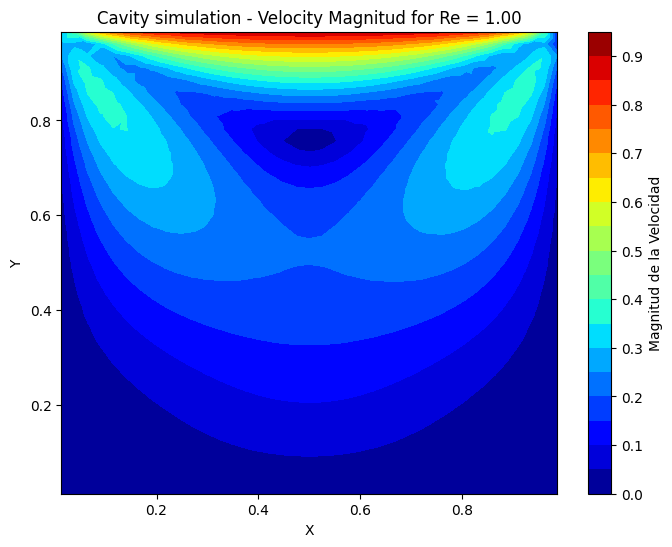

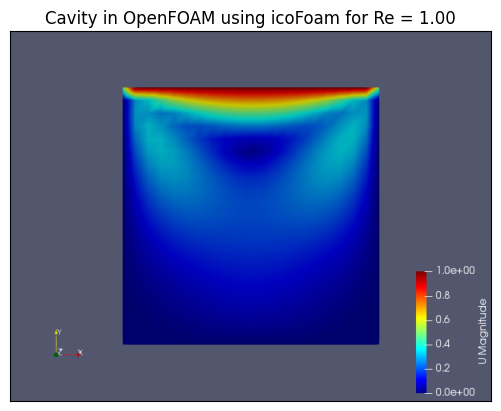

In [22]:
L = 1
N = 40  # Número de nodos en cada dirección
cavity = Cavity_SIMPLE(L, N)

Se puede ver que los resultados son bastante similares al obtenido en el ejemplo de OpenFoam. Sin embargo, este algoritmo se demora mucho más (yo tengo un Macbook Pro M1 del 2020 y se demora aprox 25 minutos)